## Purpose of this script is to create features to be used in model creation 

In [149]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import time
import datetime
%matplotlib inline

Load data from processed dataset

In [150]:
matches_raw = pd.read_csv('/Users/mtetkosk/Google Drive/Data Science Projects/data/processed/EPL_Matches_Reduced.csv')

matches=matches_raw.copy()
print len(matches)
print matches.shape

3040
(3040, 27)


In [151]:
matches.head()

,id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,B365H,...,IWA,LBH,LBD,LBA,WHH,WHD,WHA,VCH,VCD,VCA
0,1729,2008/2009,1,8/17/08 0:00,489042,10260,10261,1,1,1.29,...,8.50,1.25,4.5,10.00,1.25,4.5,10.00,1.28,5.5,12.00
1,1730,2008/2009,1,8/16/08 0:00,489043,9825,8659,1,0,1.20,...,11.00,1.20,5.0,11.00,1.17,5.5,12.00,1.25,6.0,13.00
2,1731,2008/2009,1,8/16/08 0:00,489044,8472,8650,0,1,5.50,...,1.65,4.50,3.3,1.67,5.50,3.3,1.57,5.50,3.8,1.65
3,1732,2008/2009,1,8/16/08 0:00,489045,8654,8528,2,1,1.91,...,3.80,1.80,3.2,4.00,1.83,3.2,3.75,1.90,3.5,4.35
4,1733,2008/2009,1,8/17/08 0:00,489046,10252,8456,4,2,1.91,...,3.30,1.83,3.2,3.75,1.91,3.2,3.50,1.90,3.5,4.35


First job is to create a target variable.

There are 3 possible outcomes:
- Home Win
- Away Win
- Draw

In [152]:
matches['Result_Target'] = np.nan

In [153]:
multiclass = True  # Use this to set the target variables

In [154]:
if multiclass:
    matches.ix[matches['home_team_goal'] > matches['away_team_goal'], 'Result_Target'] = 1
    matches.ix[matches['home_team_goal'] < matches['away_team_goal'], 'Result_Target'] = -1
    matches.ix[matches['home_team_goal'] == matches['away_team_goal'], 'Result_Target'] = 0
else:
    matches.ix[matches['home_team_goal'] > matches['away_team_goal'], 'Result_Target'] = 0
    matches.ix[matches['home_team_goal'] < matches['away_team_goal'], 'Result_Target'] = 0
    matches.ix[matches['home_team_goal'] == matches['away_team_goal'], 'Result_Target'] = 1    

 1.0    1390
-1.0     867
 0.0     783
Name: Result_Target, dtype: int64


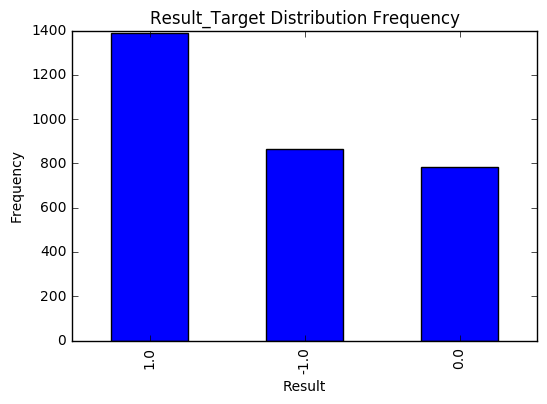

In [155]:
matches['Result_Target'].value_counts().plot(kind = 'bar')
plt.xlabel('Result')
plt.ylabel('Frequency')
plt.title('Result_Target Distribution Frequency')
print matches['Result_Target'].value_counts()

In [156]:
matches.head()  # Sanity check that the results column makes sense - Looks Ok!

,id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,B365H,...,LBH,LBD,LBA,WHH,WHD,WHA,VCH,VCD,VCA,Result_Target
0,1729,2008/2009,1,8/17/08 0:00,489042,10260,10261,1,1,1.29,...,1.25,4.5,10.00,1.25,4.5,10.00,1.28,5.5,12.00,0.0
1,1730,2008/2009,1,8/16/08 0:00,489043,9825,8659,1,0,1.20,...,1.20,5.0,11.00,1.17,5.5,12.00,1.25,6.0,13.00,1.0
2,1731,2008/2009,1,8/16/08 0:00,489044,8472,8650,0,1,5.50,...,4.50,3.3,1.67,5.50,3.3,1.57,5.50,3.8,1.65,-1.0
3,1732,2008/2009,1,8/16/08 0:00,489045,8654,8528,2,1,1.91,...,1.80,3.2,4.00,1.83,3.2,3.75,1.90,3.5,4.35,1.0
4,1733,2008/2009,1,8/17/08 0:00,489046,10252,8456,4,2,1.91,...,1.83,3.2,3.75,1.91,3.2,3.50,1.90,3.5,4.35,1.0


### Feature Creation Step

The function below returns 3 dictionaries for each season:
     - Team Standings
     - Team Goal Difference
     - Team Results String (win, loss, draw)

In [157]:
def SeasonStanding(season):
    
    stages = range(1,39)
    
    points_dict = {}
    goal_diff = {}
    stage_dict = {}
    goal_diff_stage = {}
    team_results = {}
    
    for stage in stages:
        
        sub = season[season['stage']==stage]
        sub = sub.reset_index(drop = True)

        for i in range(len(sub)):
            
            home_goal = sub['home_team_goal'][i]
            away_goal = sub['away_team_goal'][i]
                
            if home_goal > away_goal:  ## home_win
                
                # Points
                if sub['home_team_api_id'][i] in points_dict.keys():
                    points_dict[sub['home_team_api_id'][i]] +=3
                else:
                    points_dict[sub['home_team_api_id'][i]] = 3
                if sub['away_team_api_id'][i] not in points_dict.keys():
                    points_dict[sub['away_team_api_id'][i]] = 0
                
                # Results
                
                if sub['home_team_api_id'][i] in team_results.keys():
                    team_results[sub['home_team_api_id'][i]].append('Win')
                else:
                    team_results[sub['home_team_api_id'][i]] = ['Win'] 
                    
                if sub['away_team_api_id'][i] in team_results.keys():
                    team_results[sub['away_team_api_id'][i]].append('Loss')
                else:
                    team_results[sub['away_team_api_id'][i]] = ['Loss']
                    
                    
                
                # Goal Difference
                if sub['home_team_api_id'][i] in goal_diff.keys():
                    goal_diff[sub['home_team_api_id'][i]] += home_goal - away_goal
                else:
                    goal_diff[sub['home_team_api_id'][i]] = home_goal - away_goal
                    
                if sub['away_team_api_id'][i] in goal_diff.keys():
                    goal_diff[sub['away_team_api_id'][i]] += away_goal - home_goal
                else:
                    goal_diff[sub['away_team_api_id'][i]] = away_goal - home_goal
                    
                continue

            if home_goal < away_goal:  ## away_win
                # Points
                if sub['away_team_api_id'][i] in points_dict.keys():
                    points_dict[sub['away_team_api_id'][i]] +=3
                else:
                    points_dict[sub['away_team_api_id'][i]] =3 
                if sub['home_team_api_id'][i] not in points_dict.keys():
                    points_dict[sub['home_team_api_id'][i]] = 0
                    
                # Results   
                if sub['home_team_api_id'][i] in team_results.keys():
                    team_results[sub['home_team_api_id'][i]].append('Loss')
                else:
                    team_results[sub['home_team_api_id'][i]] = ['Loss'] 
                    
                if sub['away_team_api_id'][i] in team_results.keys():
                    team_results[sub['away_team_api_id'][i]].append('Win')
                else:
                    team_results[sub['away_team_api_id'][i]] = ['Win']
                
                # Goal Difference 
                if sub['home_team_api_id'][i] in goal_diff.keys():
                    goal_diff[sub['home_team_api_id'][i]] += home_goal - away_goal
                else:
                    goal_diff[sub['home_team_api_id'][i]] = home_goal - away_goal
                    
                if sub['away_team_api_id'][i] in goal_diff.keys():
                    goal_diff[sub['away_team_api_id'][i]] += away_goal - home_goal
                else:
                    goal_diff[sub['away_team_api_id'][i]] = away_goal - home_goal 
                    
                    
                continue

            if sub['home_team_goal'][i] == sub['away_team_goal'][i]:
                # Points
                if sub['away_team_api_id'][i] in points_dict.keys():
                    points_dict[sub['away_team_api_id'][i]] +=1
                else:
                    points_dict[sub['away_team_api_id'][i]] = 1     
                if sub['home_team_api_id'][i] in points_dict.keys():
                    points_dict[sub['home_team_api_id'][i]] +=1
                else:
                    points_dict[sub['home_team_api_id'][i]] =1  
                    
                # Results   
                if sub['home_team_api_id'][i] in team_results.keys():
                    team_results[sub['home_team_api_id'][i]].append('Draw')
                else:
                    team_results[sub['home_team_api_id'][i]] = ['Draw'] 
                    
                if sub['away_team_api_id'][i] in team_results.keys():
                    team_results[sub['away_team_api_id'][i]].append('Draw')
                else:
                    team_results[sub['away_team_api_id'][i]] = ['Draw']
                
                # Initialize Goal Difference if Needed
                
                if sub['away_team_api_id'][i] not in goal_diff.keys():
                    goal_diff[sub['away_team_api_id'][i]] = 0
                if sub['home_team_api_id'][i] not in goal_diff.keys():
                    goal_diff[sub['home_team_api_id'][i]] = 0                

        s_data = sorted(points_dict.items(), key=lambda item: item[1])
        rank, count, previous, result = 0, 0, None, {}
    
        for key, num in s_data:
            count += 1
            if num != previous:
                rank += count
                previous = num
                count = 0
            result[key] = 21-rank

        stage_dict[stage] = result.copy()
        goal_diff_stage[stage] = goal_diff.copy()

        
    return stage_dict, goal_diff_stage,team_results

In [158]:
def LastKResults(team, stage, results_list,k):
    
    if (stage-1)-k >= 0:
        results = results_list[(stage-1)-k:stage-1]
        wins_count = results.count('Win')
        loss_count = results.count('Loss')
        draw_count = results.count('Draw')
  
        return wins_count, loss_count, draw_count   

    else:
        wins_count = -1
        loss_count = -1
        draw_count = -1
        
        return wins_count, loss_count, draw_count
    


## Season Stats

In [159]:
def CreateSeasonStats(df_in,last_k):
    
    df = df_in.copy()  #make a copy of the input data to avoid setting copy on df slices
    
    seasons = list(matches['season'].unique())
    
    # set up master dictionaries
    season_standings = {}
    season_goal_difference = {}
    season_results = {}
    
    for season in seasons: # iterate thru seasons and append to master dictionaries
        subset = df[df['season']==season]
        standings, goal_difference, results = SeasonStanding(subset)
        season_standings[season] = standings
        season_goal_difference[season] = goal_difference
        season_results[season] = results
    
    home_team_standing = []
    away_team_standing = []
    
    home_team_goal_diff = []
    away_team_goal_diff = []
    
    home_dict = {}
    away_dict = {}
    

    for i in range(len(df)):
        home_team = df['home_team_api_id'][i]
        away_team = df['away_team_api_id'][i]
        stage = df['stage'][i]
        season = df['season'][i]
        
        # Always lookup values for stage-1 because you cannot append values of the current game week. Always looking up to 1 week prior
        # Standings Lookup
        if stage == 1:
            home_team_standing.append(-1)
        else:
            hts = season_standings[season][stage-1][home_team]
            home_team_standing.append(hts)
        
        if stage == 1:
            away_team_standing.append(-1)
        else:
            ats = season_standings[season][stage-1][away_team]
            away_team_standing.append(ats)
        
        # Goal Difference Lookup
        if stage == 1:
            home_team_goal_diff.append(0)
        else:
            hgd = season_goal_difference[season][stage-1][home_team]
            home_team_goal_diff.append(hgd)
        
        if stage == 1:
            away_team_goal_diff.append(0)
        else:
            agd = season_goal_difference[season][stage-1][away_team]
            away_team_goal_diff.append(agd)
        
        # Last K Results
        
        home_team_results_list = season_results[season][home_team]
        away_team_results_list = season_results[season][away_team]
        
        last_k_range = range(1,last_k)   
        
        for k_val in last_k_range:
            hwc,hlc,hdc = LastKResults(home_team,stage,home_team_results_list,k_val)
            awc,alc,adc = LastKResults(away_team,stage,away_team_results_list,k_val)
                        
            if k_val not in home_dict.keys():
                home_dict[k_val] = {'Wins' : [hwc],'Draws' : [hdc],'Losses':[hlc]}
                away_dict[k_val] = {'Wins' : [awc],'Draws' : [adc], 'Losses':[alc]}
            else:
                home_dict[k_val]['Wins'].append(hwc)
                home_dict[k_val]['Draws'].append(hdc)
                home_dict[k_val]['Losses'].append(hlc)
                
                away_dict[k_val]['Wins'].append(awc)
                away_dict[k_val]['Draws'].append(adc)
                away_dict[k_val]['Losses'].append(alc)                
                
            
    for val in home_dict.keys():
        df['Home_Team_Last_%d_Wins'%(val)] = home_dict[val]['Wins']
        df['Home_Team_Last_%d_Draws'%(val)] = home_dict[val]['Draws']
        df['Home_Team_Last_%d_Losses'%(val)] = home_dict[val]['Losses']
        
        df['Away_Team_Last_%d_Wins'%(val)] = away_dict[val]['Wins']
        df['Away_Team_Last_%d_Draws'%(val)] = away_dict[val]['Draws']
        df['Away_Team_Last_%d_Losses'%(val)] = away_dict[val]['Losses']
              
    df['Home_Standing'] = home_team_standing
    df['Away_Standing'] = away_team_standing
    df['Home_Goal_Diff'] = home_team_goal_diff
    df['Away_Goal_Diff'] = away_team_goal_diff
    df['Standing_Diff'] = df['Home_Standing']- df['Away_Standing']
    df['Diff_Goal_Diff'] = df['Home_Goal_Diff'] - df['Away_Goal_Diff']
        
    return df

In [160]:
matches = CreateSeasonStats(matches,10)
matches.head(30)

,id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,B365H,...,Home_Team_Last_9_Losses,Away_Team_Last_9_Wins,Away_Team_Last_9_Draws,Away_Team_Last_9_Losses,Home_Standing,Away_Standing,Home_Goal_Diff,Away_Goal_Diff,Standing_Diff,Diff_Goal_Diff
0,1729,2008/2009,1,8/17/08 0:00,489042,10260,10261,1,1,1.29,...,-1,-1,-1,-1,-1,-1,0,0,0,0
1,1730,2008/2009,1,8/16/08 0:00,489043,9825,8659,1,0,1.20,...,-1,-1,-1,-1,-1,-1,0,0,0,0
2,1731,2008/2009,1,8/16/08 0:00,489044,8472,8650,0,1,5.50,...,-1,-1,-1,-1,-1,-1,0,0,0,0
3,1732,2008/2009,1,8/16/08 0:00,489045,8654,8528,2,1,1.91,...,-1,-1,-1,-1,-1,-1,0,0,0,0
4,1733,2008/2009,1,8/17/08 0:00,489046,10252,8456,4,2,1.91,...,-1,-1,-1,-1,-1,-1,0,0,0,0
5,1734,2008/2009,1,8/16/08 0:00,489047,8668,8655,2,3,2.00,...,-1,-1,-1,-1,-1,-1,0,0,0,0
6,1735,2008/2009,1,8/16/08 0:00,489048,8549,8586,2,1,3.20,...,-1,-1,-1,-1,-1,-1,0,0,0,0
7,1736,2008/2009,1,8/16/08 0:00,489049,8559,10194,3,1,1.83,...,-1,-1,-1,-1,-1,-1,0,0,0,0
8,1737,2008/2009,1,8/16/08 0:00,489050,8667,9879,2,1,2.60,...,-1,-1,-1,-1,-1,-1,0,0,0,0
9,1738,2008/2009,1,8/17/08 0:00,489051,8455,8462,4,0,1.33,...,-1,-1,-1,-1,-1,-1,0,0,0,0


##### Aggregated Odds - Average

In [161]:
## Betting Odds Columns
odds = matches[matches.columns[9:27]].copy()
odds.head()

,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,LBD,LBA,WHH,WHD,WHA,VCH,VCD,VCA
0,1.29,5.5,11.00,1.30,4.75,8.25,1.3,4.4,8.50,1.25,4.5,10.00,1.25,4.5,10.00,1.28,5.5,12.00
1,1.20,6.5,15.00,1.22,5.50,10.00,1.2,5.2,11.00,1.20,5.0,11.00,1.17,5.5,12.00,1.25,6.0,13.00
2,5.50,3.6,1.67,5.00,3.35,1.67,4.5,3.5,1.65,4.50,3.3,1.67,5.50,3.3,1.57,5.50,3.8,1.65
3,1.91,3.4,4.20,1.90,3.20,3.80,1.8,3.3,3.80,1.80,3.2,4.00,1.83,3.2,3.75,1.90,3.5,4.35
4,1.91,3.4,4.33,1.95,3.20,3.60,2.0,3.2,3.30,1.83,3.2,3.75,1.91,3.2,3.50,1.90,3.5,4.35


In [162]:
home_odds = []
away_odds = []
draw_odds = []

for colname in odds.columns:
    if colname in ['WHH','WHD','WHA']:
        if colname == 'WHH':
            home_odds.append(colname)
        elif colname == 'WHD':
            draw_odds.append(colname)
        elif colname == 'WHA':
            away_odds.append(colname)
        continue
    if 'H' in colname:
        home_odds.append(colname)
    elif 'A' in colname:
        away_odds.append(colname)
    else:
        draw_odds.append(colname)

In [163]:
# Fill null values with the average of each row

matches['BWH'].fillna(odds[home_odds].mean(axis=1),inplace = True)
matches['IWH'].fillna(odds[home_odds].mean(axis=1),inplace = True)
matches['LBH'].fillna(odds[home_odds].mean(axis=1),inplace = True)
matches['BWD'].fillna(odds[home_odds].mean(axis=1),inplace = True)
matches['IWD'].fillna(odds[home_odds].mean(axis=1),inplace = True)
matches['LBD'].fillna(odds[home_odds].mean(axis=1),inplace = True)
matches['BWA'].fillna(odds[home_odds].mean(axis=1),inplace = True)
matches['IWA'].fillna(odds[home_odds].mean(axis=1),inplace = True)
matches['LBA'].fillna(odds[home_odds].mean(axis=1),inplace = True)


In [164]:
odds[home_odds].head()

,B365H,BWH,IWH,LBH,WHH,VCH
0,1.29,1.30,1.3,1.25,1.25,1.28
1,1.20,1.22,1.2,1.20,1.17,1.25
2,5.50,5.00,4.5,4.50,5.50,5.50
3,1.91,1.90,1.8,1.80,1.83,1.90
4,1.91,1.95,2.0,1.83,1.91,1.90


In [165]:
matches['Average_Home_Odds'] = odds[home_odds].mean(axis=1).round(2)
matches['Average_Away_Odds'] = odds[away_odds].mean(axis=1).round(2)
matches['Average_Draw_Odds'] = odds[draw_odds].mean(axis=1).round(2)

In [166]:
matches.head()

,id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,B365H,...,Away_Team_Last_9_Losses,Home_Standing,Away_Standing,Home_Goal_Diff,Away_Goal_Diff,Standing_Diff,Diff_Goal_Diff,Average_Home_Odds,Average_Away_Odds,Average_Draw_Odds
0,1729,2008/2009,1,8/17/08 0:00,489042,10260,10261,1,1,1.29,...,-1,-1,-1,0,0,0,0,1.28,9.96,4.86
1,1730,2008/2009,1,8/16/08 0:00,489043,9825,8659,1,0,1.20,...,-1,-1,-1,0,0,0,0,1.21,12.00,5.62
2,1731,2008/2009,1,8/16/08 0:00,489044,8472,8650,0,1,5.50,...,-1,-1,-1,0,0,0,0,5.08,1.65,3.48
3,1732,2008/2009,1,8/16/08 0:00,489045,8654,8528,2,1,1.91,...,-1,-1,-1,0,0,0,0,1.86,3.98,3.30
4,1733,2008/2009,1,8/17/08 0:00,489046,10252,8456,4,2,1.91,...,-1,-1,-1,0,0,0,0,1.92,3.80,3.28


In [167]:
matches[home_odds].head()

,B365H,BWH,IWH,LBH,WHH,VCH
0,1.29,1.30,1.3,1.25,1.25,1.28
1,1.20,1.22,1.2,1.20,1.17,1.25
2,5.50,5.00,4.5,4.50,5.50,5.50
3,1.91,1.90,1.8,1.80,1.83,1.90
4,1.91,1.95,2.0,1.83,1.91,1.90


In [168]:
matches[away_odds].head()

,B365A,BWA,IWA,LBA,WHA,VCA
0,11.00,8.25,8.50,10.00,10.00,12.00
1,15.00,10.00,11.00,11.00,12.00,13.00
2,1.67,1.67,1.65,1.67,1.57,1.65
3,4.20,3.80,3.80,4.00,3.75,4.35
4,4.33,3.60,3.30,3.75,3.50,4.35


In [169]:
matches[draw_odds].head()

,B365D,BWD,IWD,LBD,WHD,VCD
0,5.5,4.75,4.4,4.5,4.5,5.5
1,6.5,5.50,5.2,5.0,5.5,6.0
2,3.6,3.35,3.5,3.3,3.3,3.8
3,3.4,3.20,3.3,3.2,3.2,3.5
4,3.4,3.20,3.2,3.2,3.2,3.5


All columns look ok! Let's finally check and make sure there are no NAN values

In [170]:
null_dict = {}

for col in matches.columns:
    nulls = matches[col].isnull().sum()
    if nulls > 0:
        null_dict[col] = nulls

null_dict

{}

##### Last K-Goals

This feature will create 4 new features
- Home_Team_Last_K_Scored
- Home_Team_Last_K_Conceded
- Away_Team_Last_K_Scored
- Away_Team_Last_K_Conceded

Games where last k value cannot be calculated, attribute will be imputed with -1

In [171]:
def LastKGoals(season_df,k):
    
    
    ## Function output:
    ##  DataFrame {match_api_id, home_team_last_k_scored , home_team_last_k_conceded, away_team_last_k_scored, away_team_last_k_conceded}
    
    home_team_last_k_scored = []
    home_team_last_k_conceded = []
    away_team_last_k_scored = []
    away_team_last_k_conceded = []
    match_api_id = []
    
    for i in range(1,39):
        # if last-k metric cannot be computed, impute with -1
        if i <= k:
            subset = season_df[season_df['stage'] == i]
            match_id = subset['match_api_id'].tolist()
            match_api_id.extend(match_id)
            
            # Impute values of -1 where last-k metric cannot be computed
            home_team_last_k_scored.extend([-1]*10)
            home_team_last_k_conceded.extend([-1]*10)
            away_team_last_k_scored.extend([-1]*10)
            away_team_last_k_conceded.extend([-1]*10)
            
            continue       

        #create subset of games in the k-stages before
        subset = season_df[season_df['stage'] >= i-k]
        subset = subset[subset['stage'] < i]
        
        cur_stage = season_df[season_df['stage'] == i]
        
        home_teams = cur_stage['home_team_api_id'].tolist()
        away_teams = cur_stage['away_team_api_id'].tolist()
        match_api_id.extend(cur_stage['match_api_id'].tolist())
        
        for team in home_teams:
            prev_home = subset[subset['home_team_api_id'] == team]
            prev_away = subset[subset['away_team_api_id'] == team]
            
            #last-k-scored
            prev_home_scored = prev_home['home_team_goal'][subset['home_team_api_id'] == team].tolist()
            prev_away_scored = prev_away['away_team_goal'][subset['away_team_api_id'] == team].tolist()
            #last-k-conceded
            prev_home_conceded = prev_home['away_team_goal'][subset['home_team_api_id'] == team].tolist()
            prev_away_conceded = prev_away['home_team_goal'][subset['away_team_api_id'] == team].tolist()            
            
            home_team_last_k_scored.append(sum(prev_home_scored)+sum(prev_away_scored))
            home_team_last_k_conceded.append(sum(prev_home_conceded)+sum(prev_away_conceded))
            
        for team in away_teams:
            prev_home = subset[subset['home_team_api_id'] == team]
            prev_away = subset[subset['away_team_api_id'] == team]
            
            #last-k-scored
            prev_home_scored = prev_home['home_team_goal'][subset['home_team_api_id'] == team].tolist()
            prev_away_scored = prev_away['away_team_goal'][subset['away_team_api_id'] == team].tolist()
            #last-k-conceded
            prev_home_conceded = prev_home['away_team_goal'][subset['home_team_api_id'] == team].tolist()
            prev_away_conceded = prev_away['home_team_goal'][subset['away_team_api_id'] == team].tolist()            
            
            away_team_last_k_scored.append(sum(prev_home_scored)+sum(prev_away_scored))
            away_team_last_k_conceded.append(sum(prev_home_conceded)+sum(prev_away_conceded))
    
    last_k_df = pd.DataFrame({'home_team_last_k_scored':home_team_last_k_scored,\
                                  'home_team_last_k_conceded': home_team_last_k_conceded,\
                                  'away_team_last_k_scored': away_team_last_k_scored,\
                                  'away_team_last_k_conceded':away_team_last_k_conceded,\
                                  'match_api_id':match_api_id})
    
    
    
    return last_k_df

In [172]:
def CreateLastKFeature(df,lastk):
    seasons = df['season'].unique()
    
    count = 0
    
    for year in seasons:
    
        matches_season = matches[matches['season'] == year]
    
        last_k_goals_df = LastKGoals(matches_season,lastk)
    
        if count == 0:
            home_k_scored = last_k_goals_df['home_team_last_k_scored'].tolist()
            home_k_conceded = last_k_goals_df['home_team_last_k_conceded'].tolist()
            away_k_scored = last_k_goals_df['away_team_last_k_scored'].tolist()
            away_k_conceded = last_k_goals_df['away_team_last_k_conceded'].tolist()
            match_id = last_k_goals_df['match_api_id'].tolist()
        else:
            home_k_scored.extend(last_k_goals_df['home_team_last_k_scored'].tolist())
            home_k_conceded.extend(last_k_goals_df['home_team_last_k_conceded'].tolist())
            away_k_scored.extend(last_k_goals_df['away_team_last_k_scored'].tolist())
            away_k_conceded.extend(last_k_goals_df['away_team_last_k_conceded'].tolist())
            match_id.extend(last_k_goals_df['match_api_id'].tolist())
    
        count += 1
        
        last_k_df = pd.DataFrame({'home_last_%d_scored'%(lastk):home_k_scored,\
                          'home_last_%d_conceded'%(lastk): home_k_conceded,\
                          'away_last_%d_scored'%(lastk): away_k_scored,\
                          'away_last_%d_concede'%(lastk): away_k_conceded,\
                          'match_api_id': match_id})
        
        
    return last_k_df
        
    

In [173]:
## Create features for k = 2,3,4,5

start = time.time()
for k_value in range(2,6):
    matches = matches.merge(CreateLastKFeature(matches,k_value), how='inner', on = 'match_api_id')

end = time.time()

diff = end-start

print 'Adding new k features took ' + str(round(diff,2)) + ' seconds'
print matches.shape

Adding new k features took 132.2 seconds
(3040, 107)


In [174]:
matches.tail()

,id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,B365H,...,home_last_3_conceded,home_last_3_scored,away_last_4_concede,away_last_4_scored,home_last_4_conceded,home_last_4_scored,away_last_5_concede,away_last_5_scored,home_last_5_conceded,home_last_5_scored
3035,4764,2015/2016,9,10/17/15 0:00,1988795,8466,8197,2,2,1.75,...,5,8,10,9,5,8,11,10,5,11
3036,4765,2015/2016,9,10/19/15 0:00,1988796,10003,10194,0,1,2.05,...,5,3,5,5,6,3,6,5,7,5
3037,4766,2015/2016,9,10/17/15 0:00,1988797,8586,8650,0,0,2.50,...,3,7,7,6,3,8,10,6,3,8
3038,4767,2015/2016,9,10/17/15 0:00,1988798,9817,9825,0,3,6.00,...,3,3,4,10,3,4,4,11,5,4
3039,4768,2015/2016,9,10/17/15 0:00,1988799,8659,8472,1,0,2.05,...,5,3,8,2,5,3,10,4,5,4


Lets check the results and make sure there aren't any missing values

In [175]:
null_dict = {}

for col in matches.columns:
    nulls = matches[col].isnull().sum()
    if nulls > 0:
        null_dict[col] = nulls

null_dict

{}

Great! There aren't any nulls

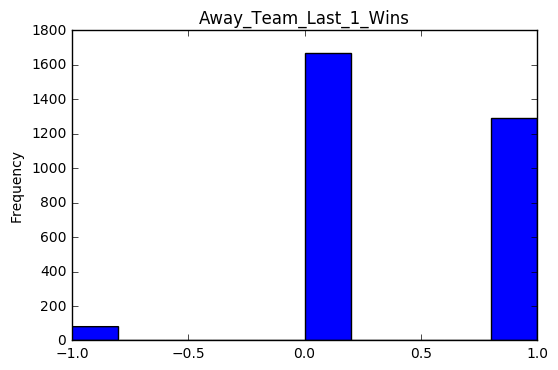

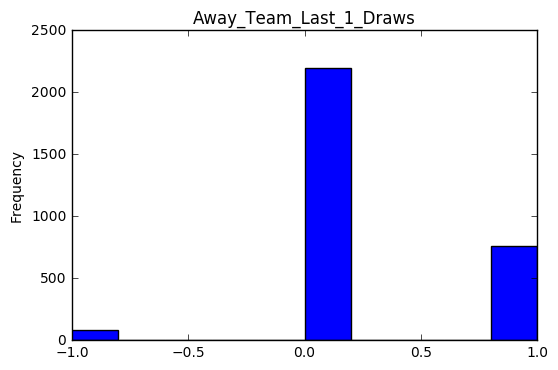

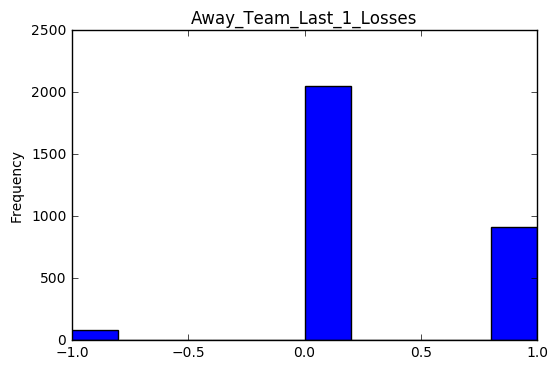

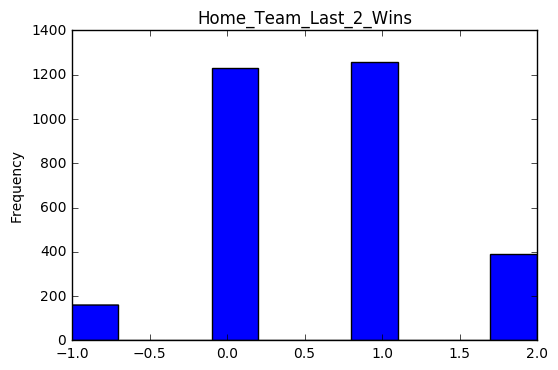

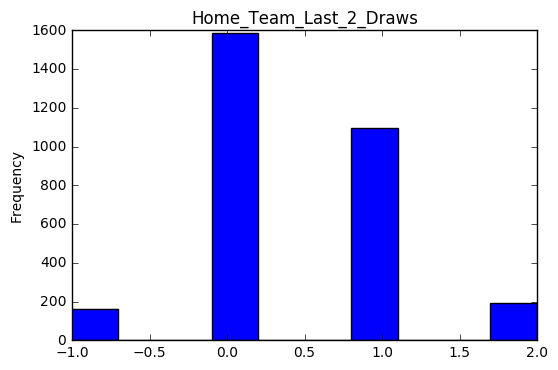

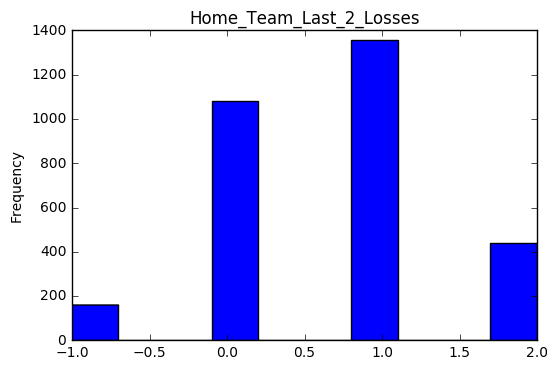

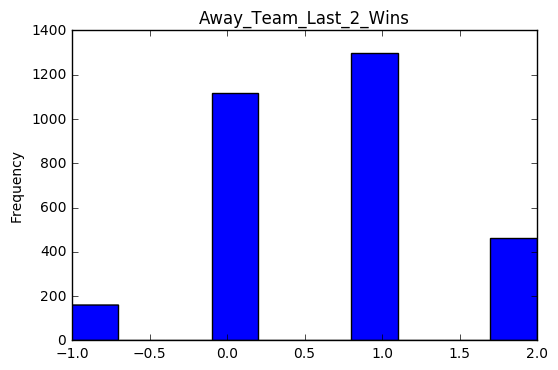

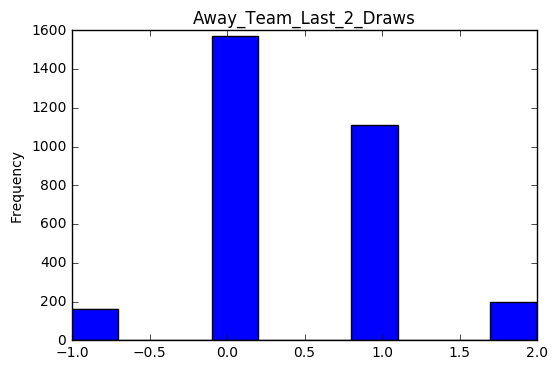

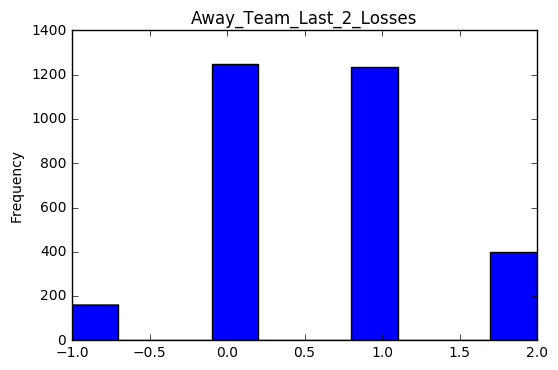

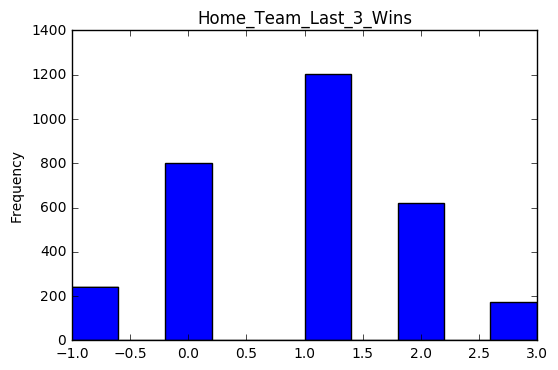

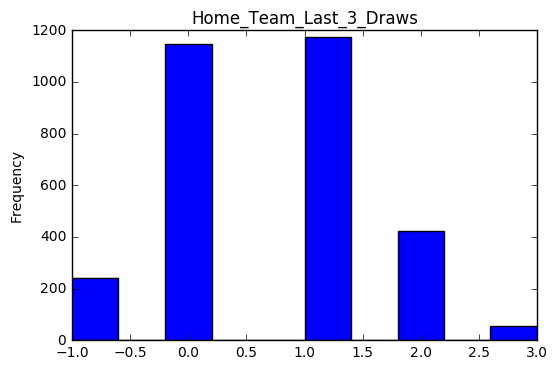

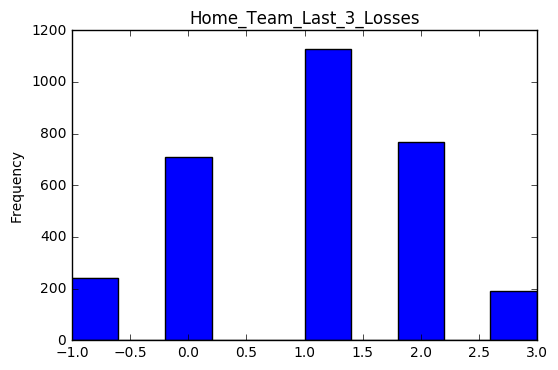

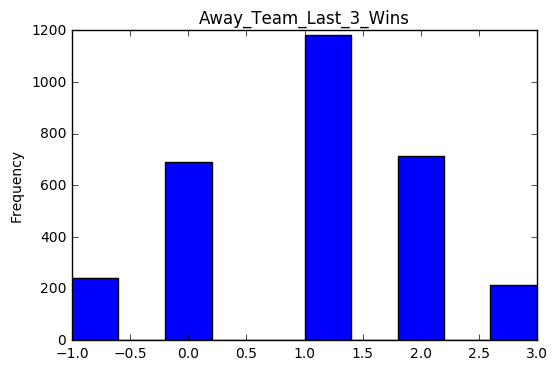

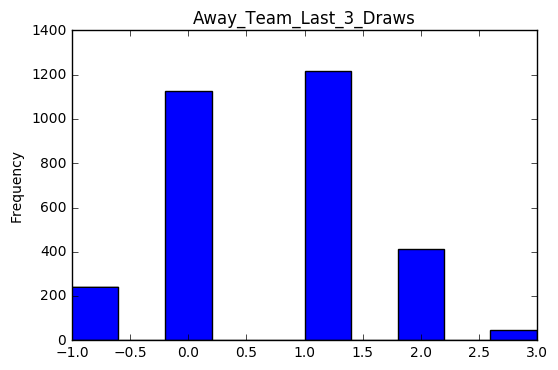

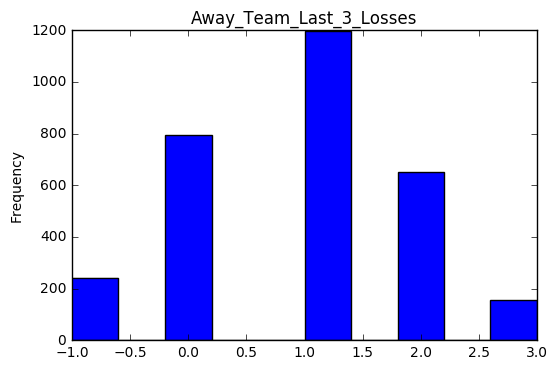

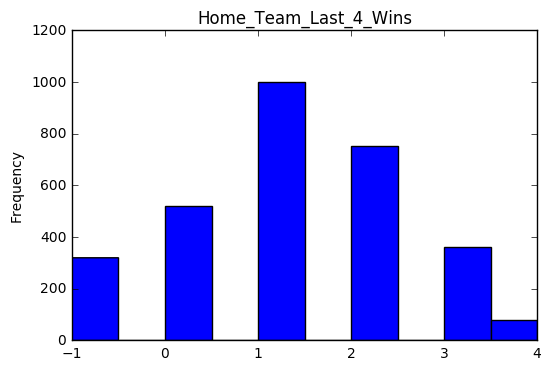

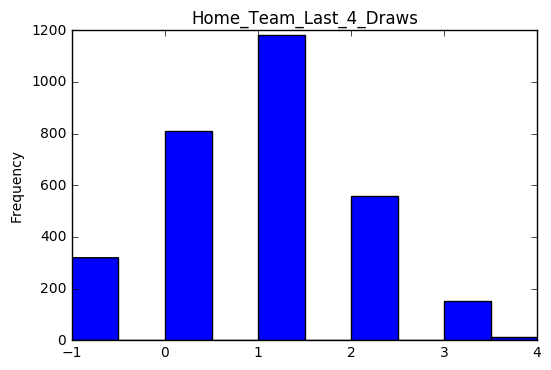

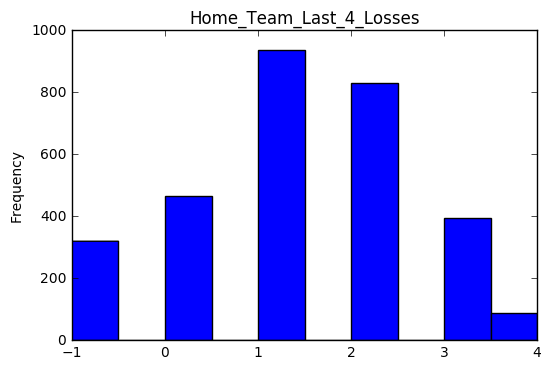

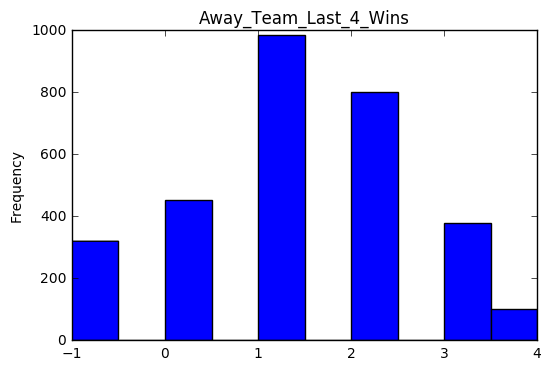

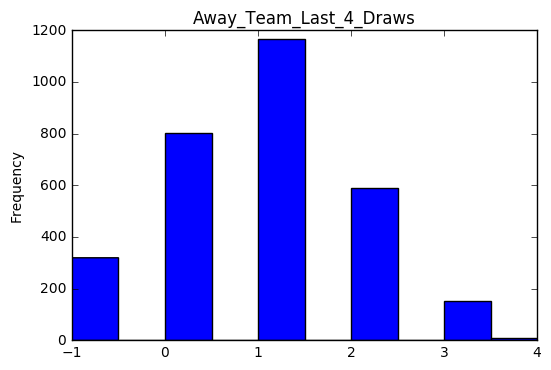

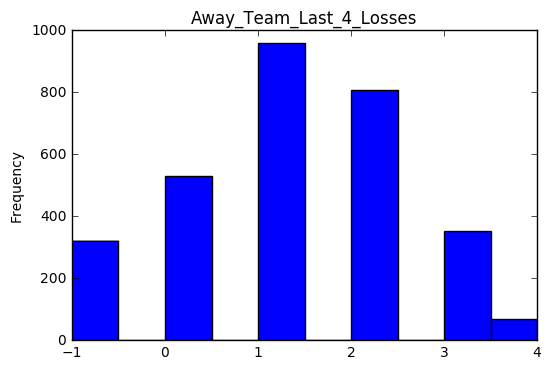

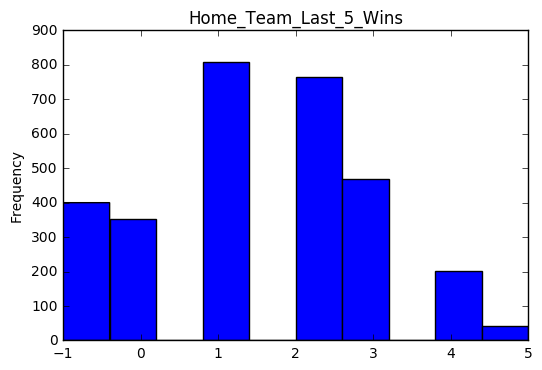

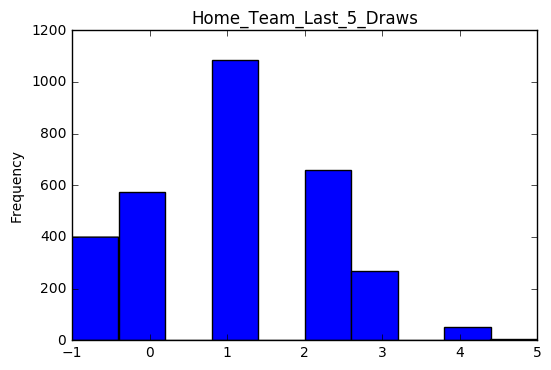

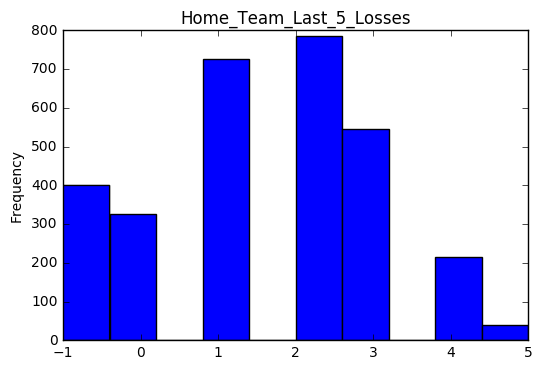

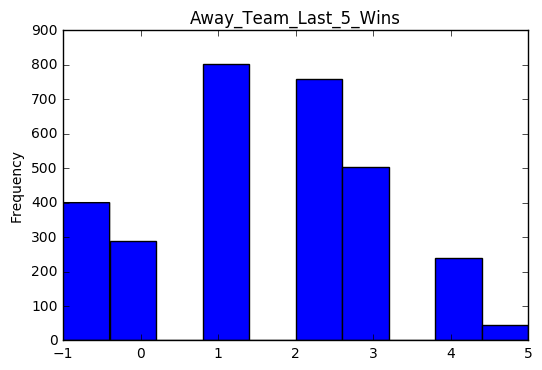

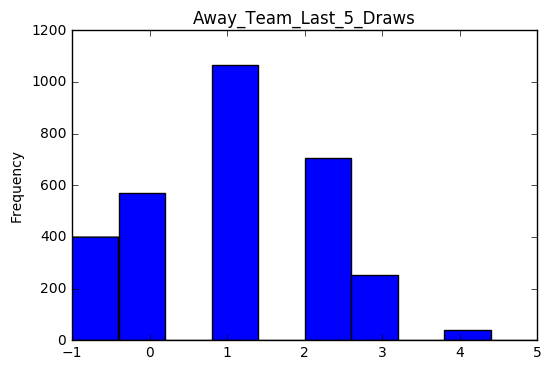

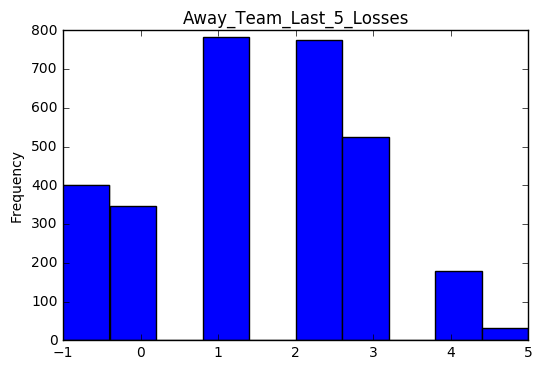

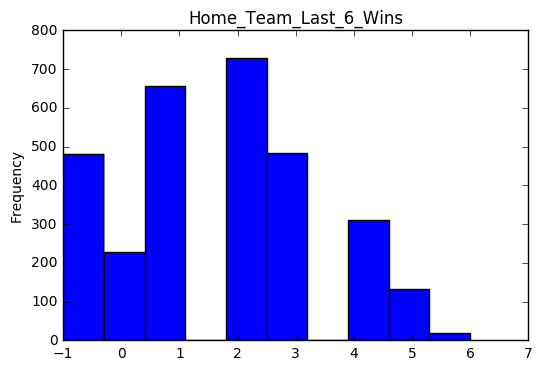

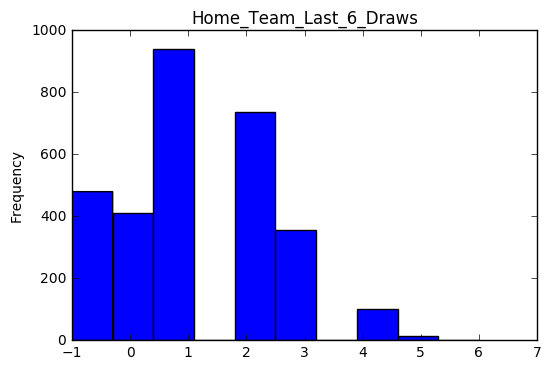

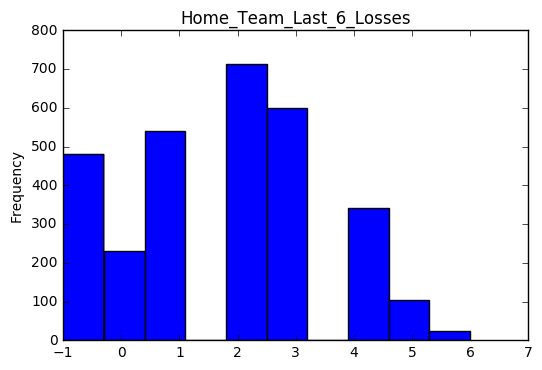

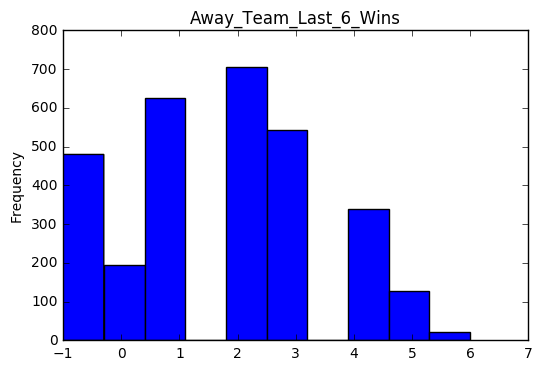

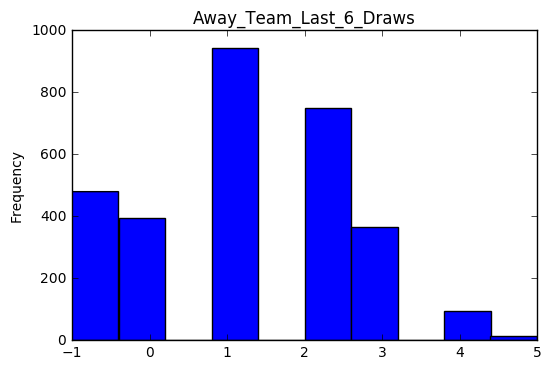

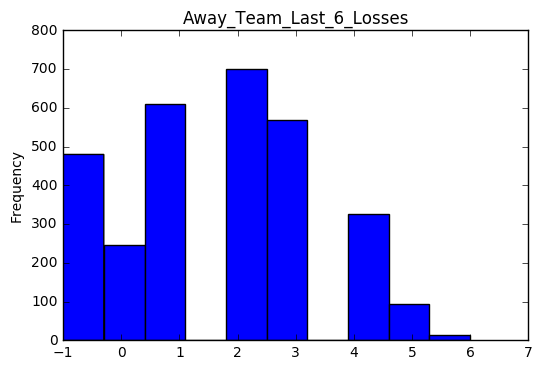

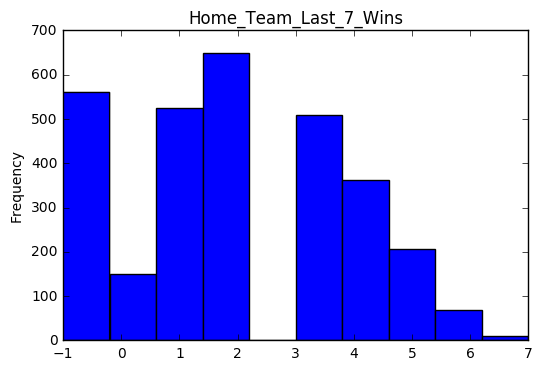

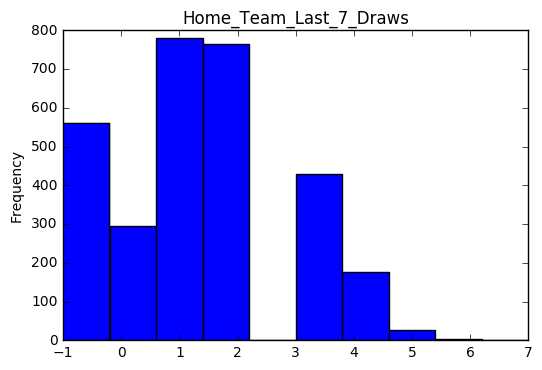

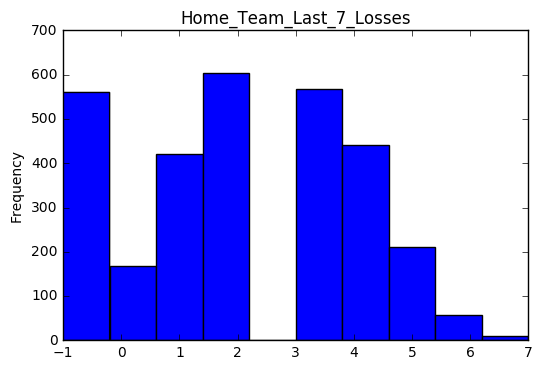

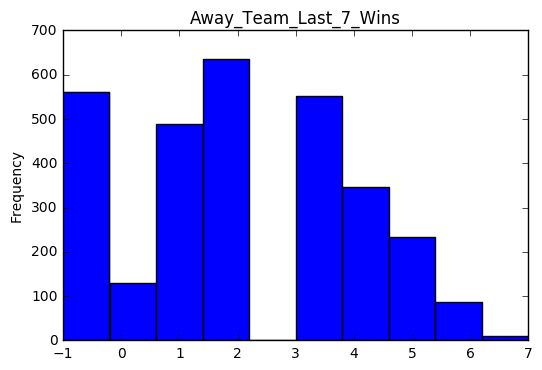

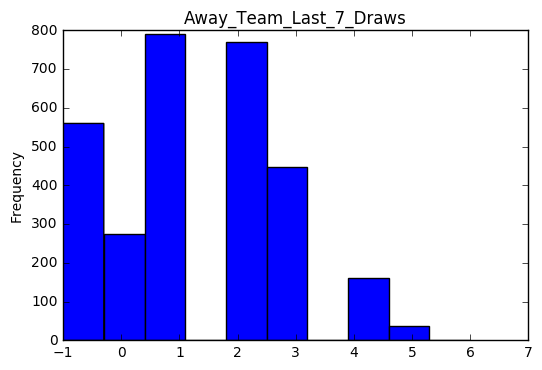

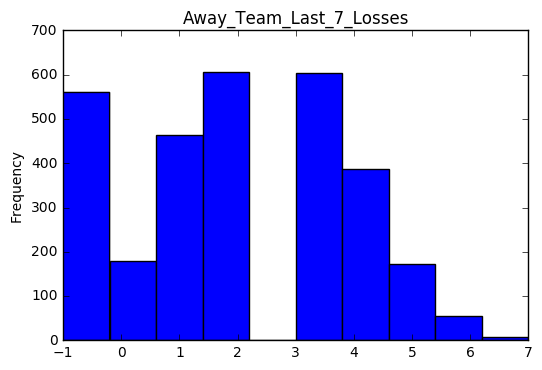

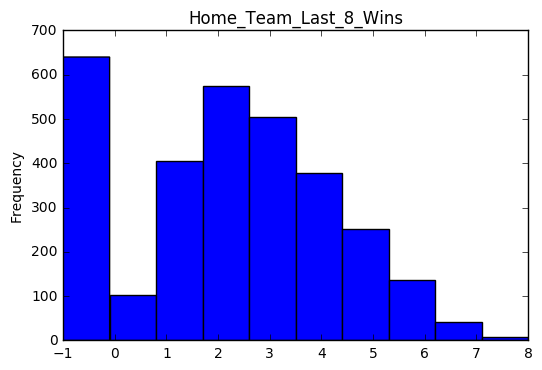

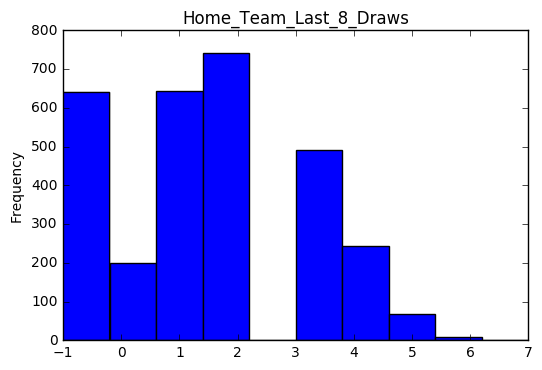

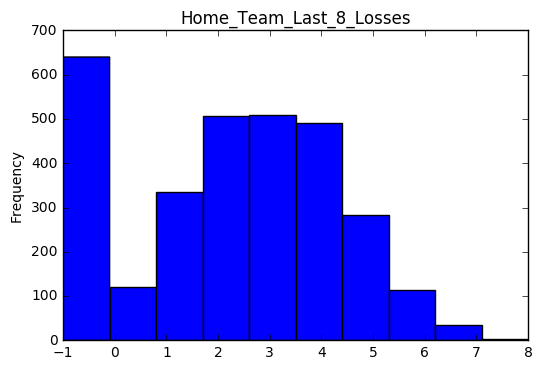

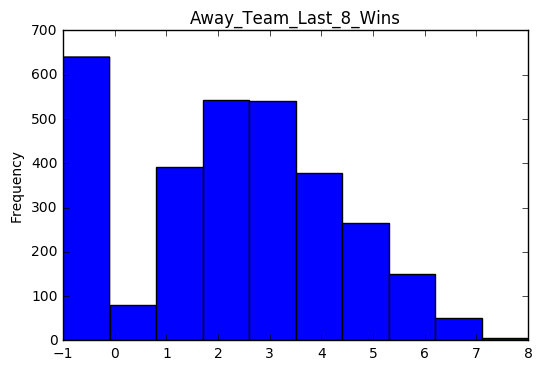

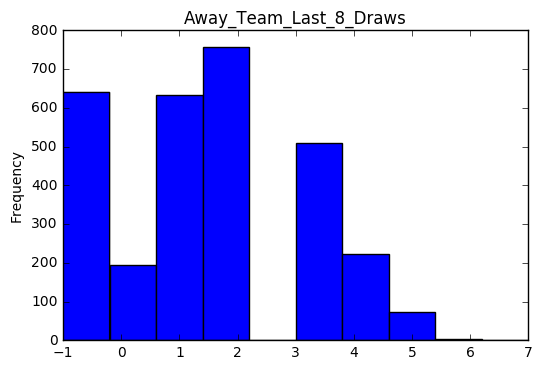

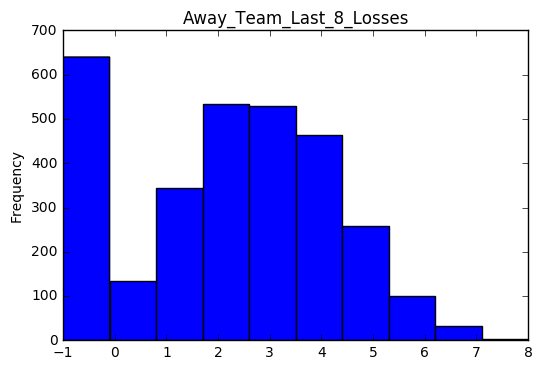

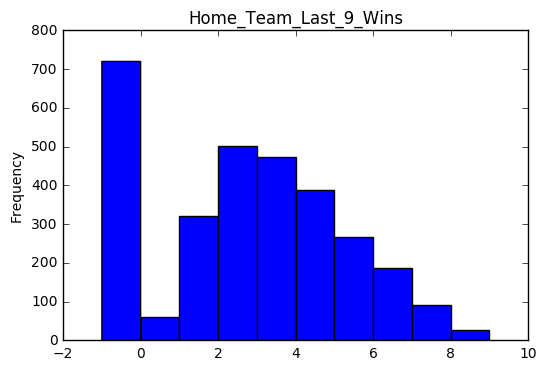

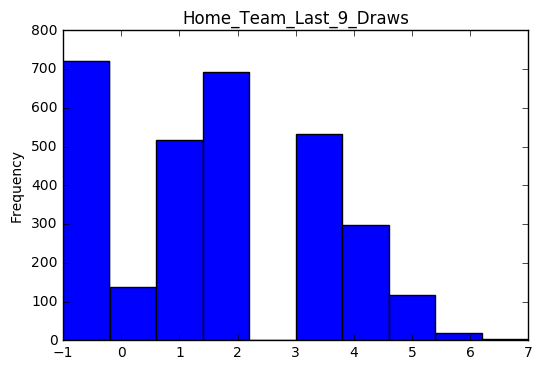

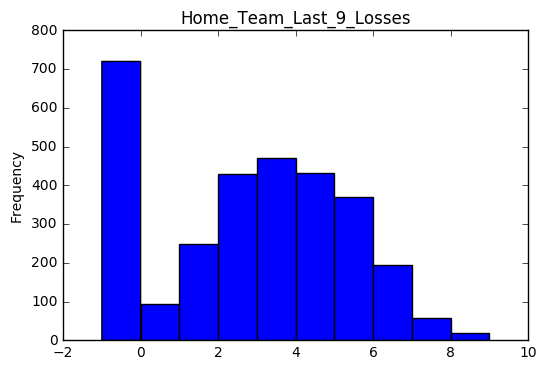

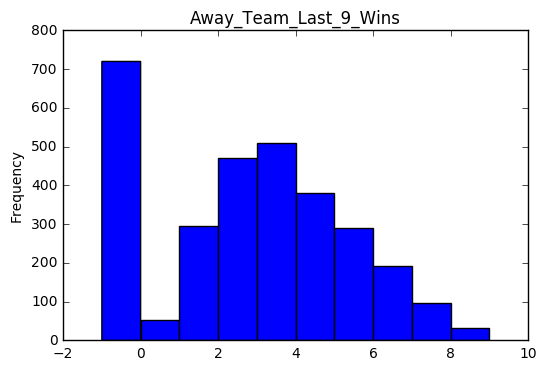

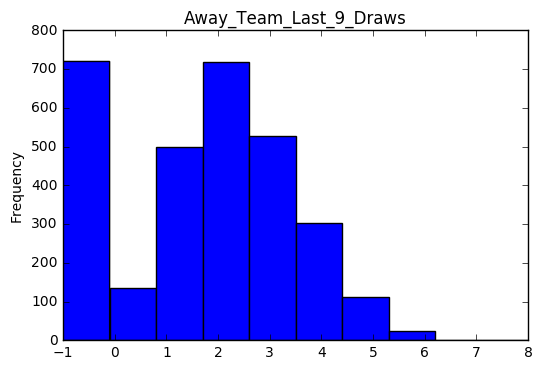

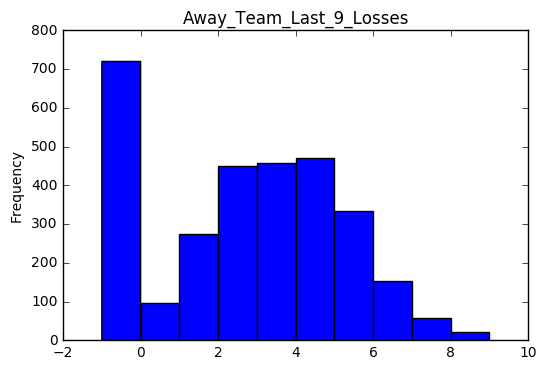

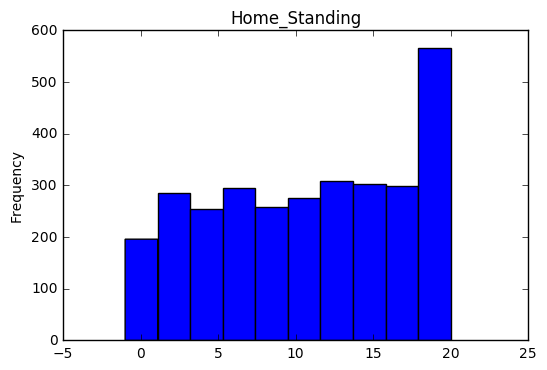

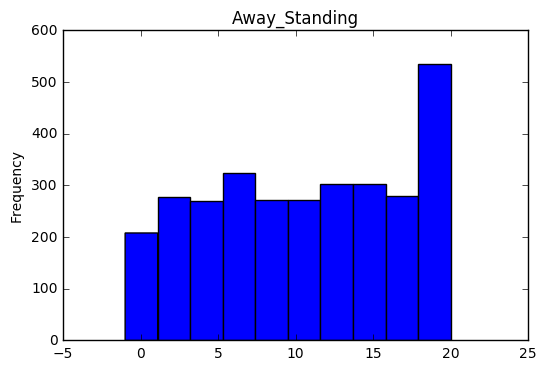

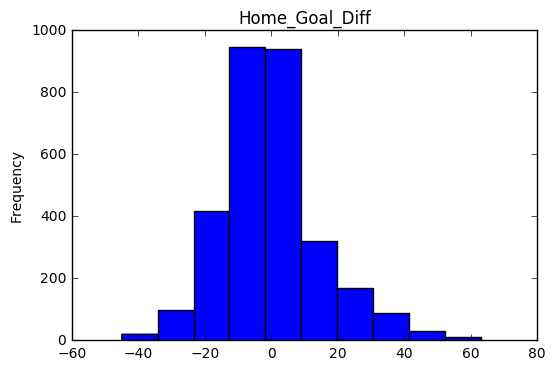

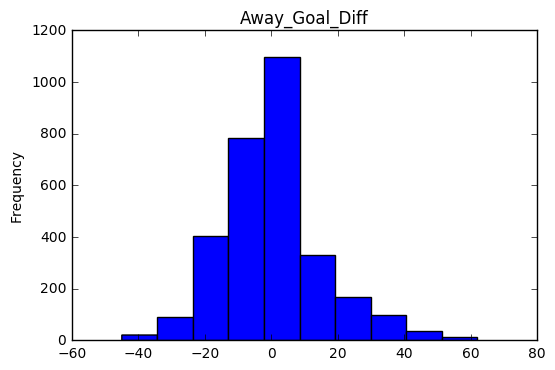

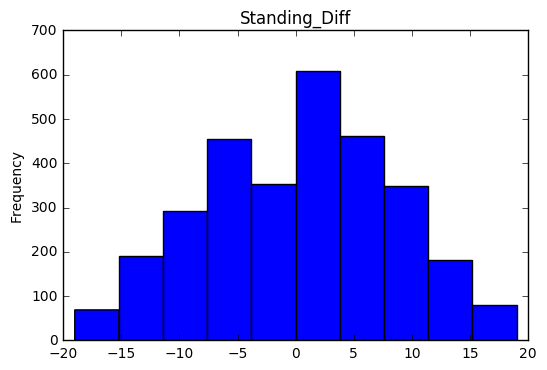

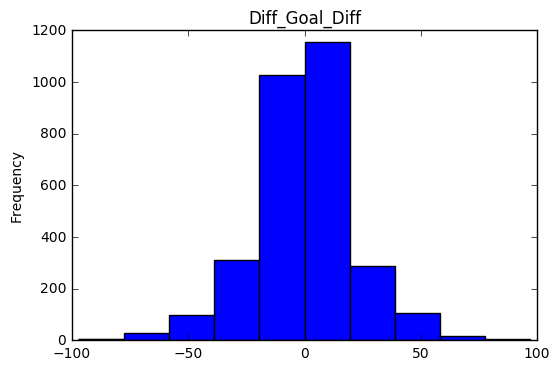

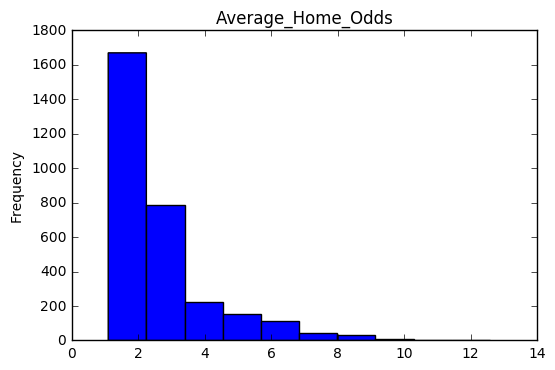

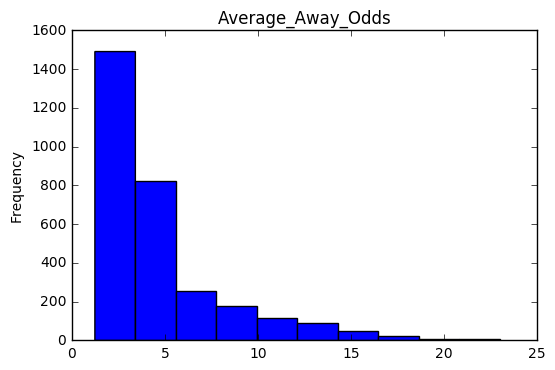

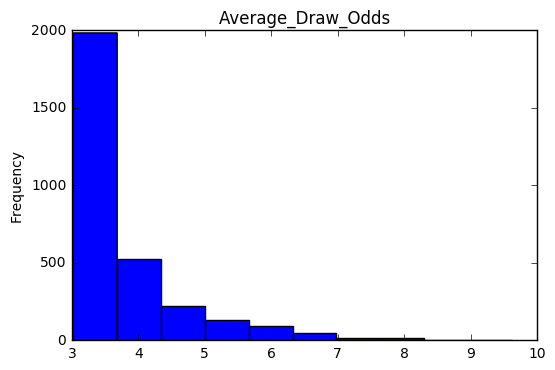

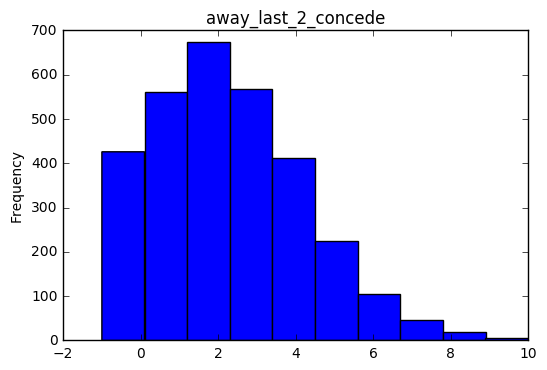

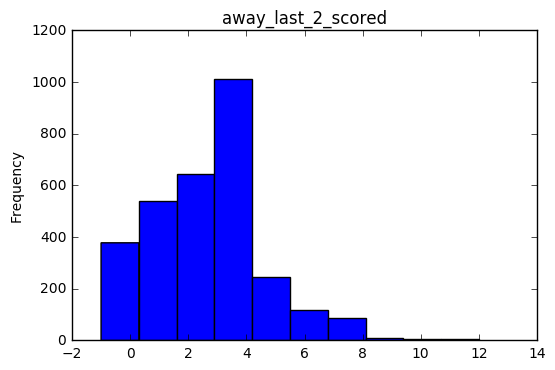

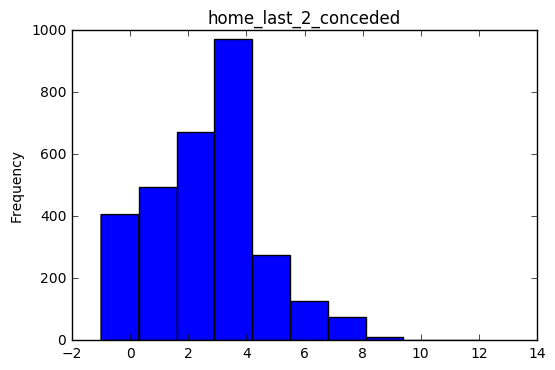

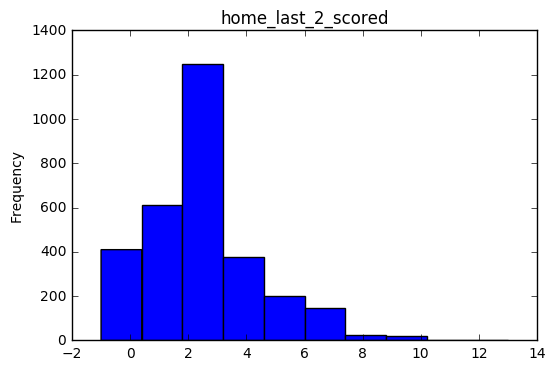

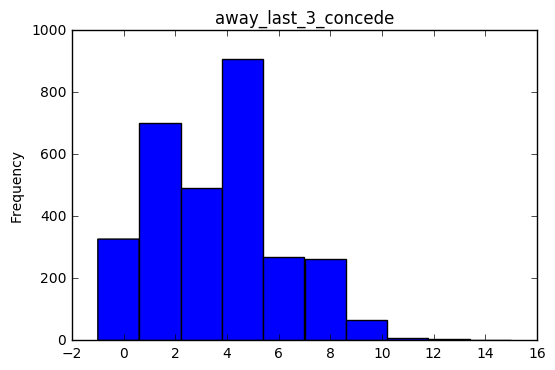

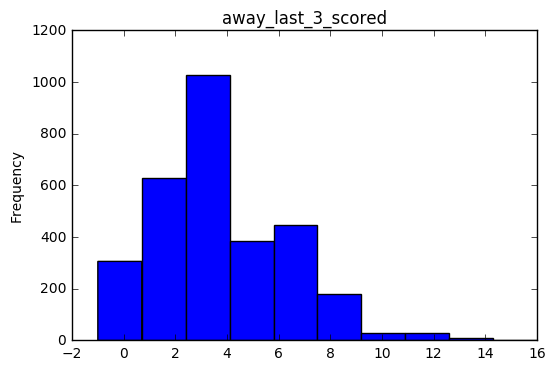

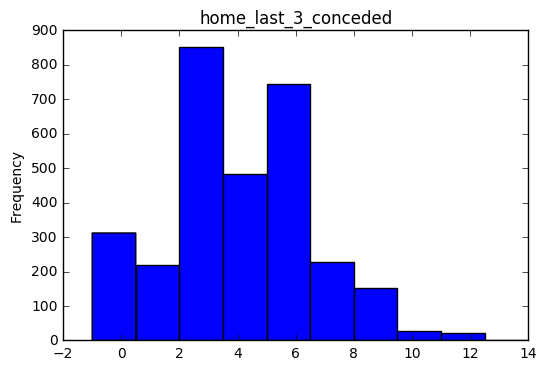

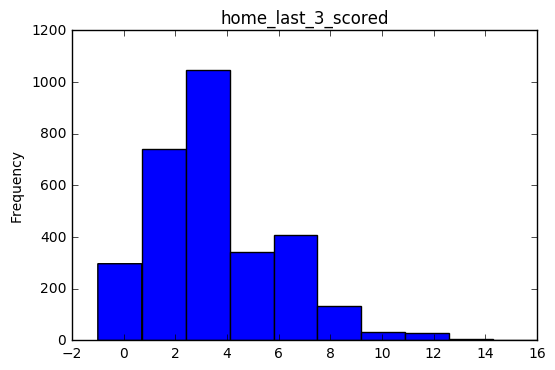

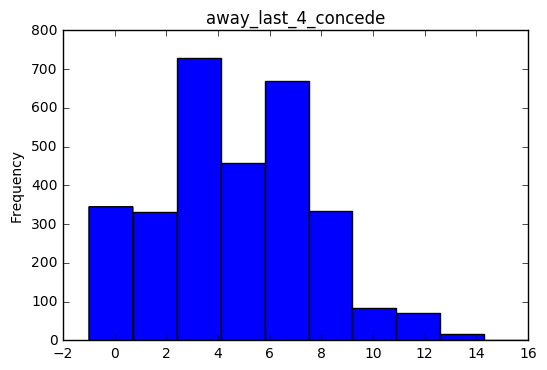

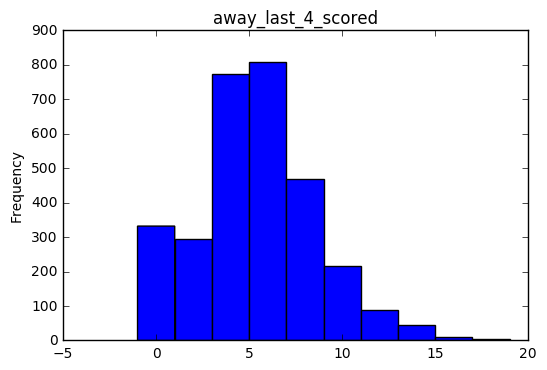

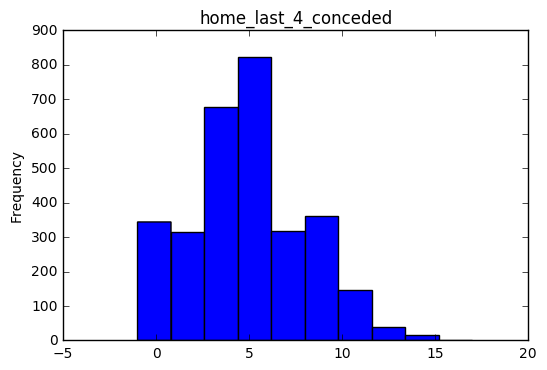

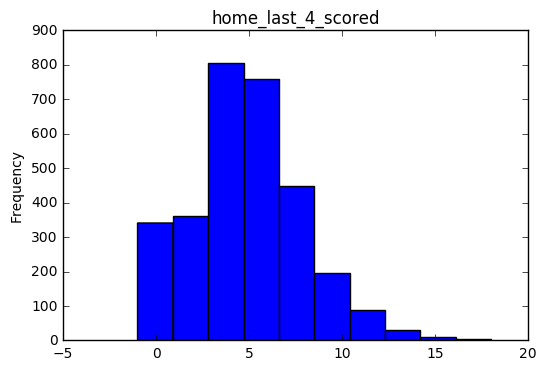

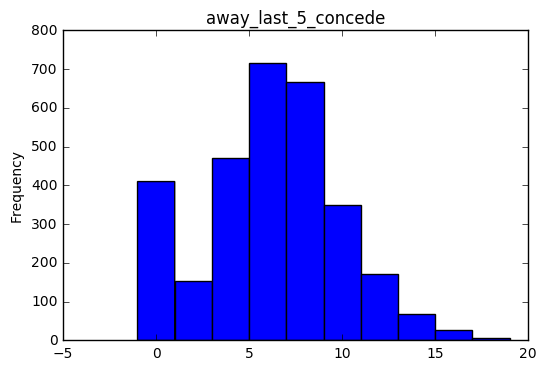

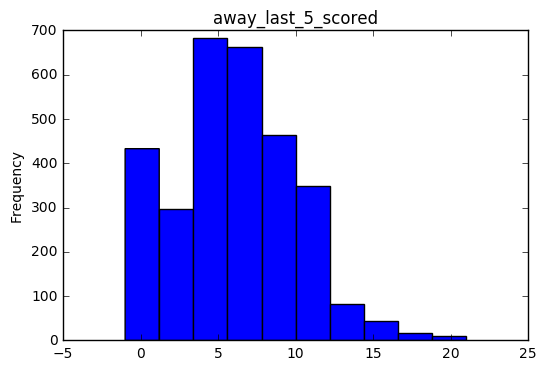

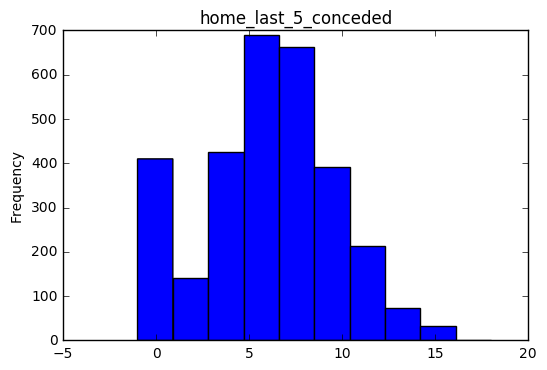

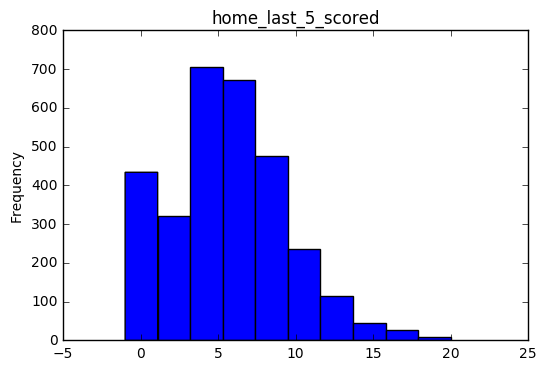

In [176]:
#Let's do some investigation on the new features

cols = matches.columns[31:]

for col in cols:
    matches[col].plot(kind='hist')
    plt.title(col)
    plt.show()

This concludes the 'last-k-goals' features!

##### Day of the week

The goal of this feature is to append a categorical feature 'Day of the Week' to each match. Because some matches happen during the middle of the week, maybe that could provide some information to the model.

In [177]:
dates_raw = matches['date'].tolist()
dates_split = []
for date in dates_raw:
    dates_split.append(date.split(' ')[0])

dates_split[0]

'8/17/08'

In [178]:
day_of_week = map(lambda x: time.strptime(x,'%m/%d/%y').tm_wday ,dates_split)

matches['day_of_week'] = day_of_week

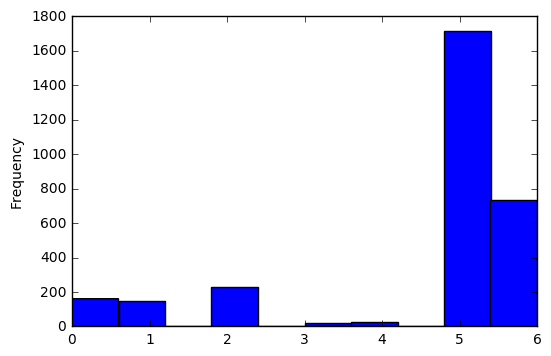

In [179]:
matches['day_of_week'].plot(kind='hist')   #Most matches played on saturday (day of week =5), but matches are also played on other days

In [180]:
matches['day_of_week'].value_counts()   #Most matches played on saturday (day of week =5), but matches are also played on other days

5    1718
6     736
2     230
0     161
1     150
4      23
3      22
Name: day_of_week, dtype: int64

In [181]:
# Let's re-investigate our matches dataframe

matches.tail()

,id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,B365H,...,home_last_3_scored,away_last_4_concede,away_last_4_scored,home_last_4_conceded,home_last_4_scored,away_last_5_concede,away_last_5_scored,home_last_5_conceded,home_last_5_scored,day_of_week
3035,4764,2015/2016,9,10/17/15 0:00,1988795,8466,8197,2,2,1.75,...,8,10,9,5,8,11,10,5,11,5
3036,4765,2015/2016,9,10/19/15 0:00,1988796,10003,10194,0,1,2.05,...,3,5,5,6,3,6,5,7,5,0
3037,4766,2015/2016,9,10/17/15 0:00,1988797,8586,8650,0,0,2.50,...,7,7,6,3,8,10,6,3,8,5
3038,4767,2015/2016,9,10/17/15 0:00,1988798,9817,9825,0,3,6.00,...,3,4,10,3,4,4,11,5,4,5
3039,4768,2015/2016,9,10/17/15 0:00,1988799,8659,8472,1,0,2.05,...,3,8,2,5,3,10,4,5,4,5


In [182]:
day_of_week_dummies = pd.get_dummies(matches['day_of_week'])
day_of_week_dummies.columns = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

#Add new binary columns to matches dataframe

matches['Monday'] = day_of_week_dummies.Monday
matches['Tuesday'] = day_of_week_dummies.Tuesday
matches['Wednesday'] = day_of_week_dummies.Wednesday
matches['Thursday'] = day_of_week_dummies.Thursday
matches['Friday'] = day_of_week_dummies.Friday
matches['Saturday'] = day_of_week_dummies.Saturday
matches['Sunday'] = day_of_week_dummies.Sunday

del matches['day_of_week']


In [183]:
matches.head()

,id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,B365H,...,away_last_5_scored,home_last_5_conceded,home_last_5_scored,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,1729,2008/2009,1,8/17/08 0:00,489042,10260,10261,1,1,1.29,...,-1,-1,-1,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1730,2008/2009,1,8/16/08 0:00,489043,9825,8659,1,0,1.20,...,-1,-1,-1,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1731,2008/2009,1,8/16/08 0:00,489044,8472,8650,0,1,5.50,...,-1,-1,-1,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1732,2008/2009,1,8/16/08 0:00,489045,8654,8528,2,1,1.91,...,-1,-1,-1,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1733,2008/2009,1,8/17/08 0:00,489046,10252,8456,4,2,1.91,...,-1,-1,-1,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Now let's add some information about each team

In [184]:
teams = pd.read_csv('/Users/mtetkosk/Google Drive/Data Science Projects/data/processed/EPL_teams.csv')
print teams.shape
teams.head()

(34, 6)


,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name,ID
0,3457,10260,11,Manchester United,MUN,10260
1,3458,10261,13,Newcastle United,NEW,10261
2,3459,9825,1,Arsenal,ARS,9825
3,3460,8659,109,West Bromwich Albion,WBA,8659
4,3461,8472,106,Sunderland,SUN,8472


In [185]:
#Let's reduce the dataframe only to the columns we need
keepcols = ['team_api_id','team_long_name']

for col in teams.columns:
    if col not in keepcols:
        del teams[col]

teams.head()

,team_api_id,team_long_name
0,10260,Manchester United
1,10261,Newcastle United
2,9825,Arsenal
3,8659,West Bromwich Albion
4,8472,Sunderland


In [186]:
matches = matches.merge(teams,how = 'left', left_on = 'home_team_api_id', right_on = 'team_api_id' )
matches = matches.merge(teams,how = 'left', left_on = 'away_team_api_id', right_on = 'team_api_id')

matches.head()

,id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,B365H,...,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,team_api_id_x,team_long_name_x,team_api_id_y,team_long_name_y
0,1729,2008/2009,1,8/17/08 0:00,489042,10260,10261,1,1,1.29,...,0.0,0.0,0.0,0.0,0.0,1.0,10260,Manchester United,10261,Newcastle United
1,1730,2008/2009,1,8/16/08 0:00,489043,9825,8659,1,0,1.20,...,0.0,0.0,0.0,0.0,1.0,0.0,9825,Arsenal,8659,West Bromwich Albion
2,1731,2008/2009,1,8/16/08 0:00,489044,8472,8650,0,1,5.50,...,0.0,0.0,0.0,0.0,1.0,0.0,8472,Sunderland,8650,Liverpool
3,1732,2008/2009,1,8/16/08 0:00,489045,8654,8528,2,1,1.91,...,0.0,0.0,0.0,0.0,1.0,0.0,8654,West Ham United,8528,Wigan Athletic
4,1733,2008/2009,1,8/17/08 0:00,489046,10252,8456,4,2,1.91,...,0.0,0.0,0.0,0.0,0.0,1.0,10252,Aston Villa,8456,Manchester City


In [187]:
remove_cols = ['team_api_id_x','team_api_id_y']

for col in matches.columns:
    if col in remove_cols:
        del matches[col]
        
matches.rename(columns={'team_long_name_x': 'Home_Team', 'team_long_name_y': 'Away_Team'}, inplace=True)

In [188]:
matches.season.value_counts()

2009/2010    380
2013/2014    380
2010/2011    380
2011/2012    380
2012/2013    380
2014/2015    380
2008/2009    380
2015/2016    380
Name: season, dtype: int64

In [189]:
print matches.head()
print matches.shape  # We now have 56 total columns (some of them we will get rid of..)

     id     season  stage          date  match_api_id  home_team_api_id  \
0  1729  2008/2009      1  8/17/08 0:00        489042             10260   
1  1730  2008/2009      1  8/16/08 0:00        489043              9825   
2  1731  2008/2009      1  8/16/08 0:00        489044              8472   
3  1732  2008/2009      1  8/16/08 0:00        489045              8654   
4  1733  2008/2009      1  8/17/08 0:00        489046             10252   

   away_team_api_id  home_team_goal  away_team_goal  B365H  \
0             10261               1               1   1.29   
1              8659               1               0   1.20   
2              8650               0               1   5.50   
3              8528               2               1   1.91   
4              8456               4               2   1.91   

           ...           home_last_5_scored  Monday  Tuesday  Wednesday  \
0          ...                           -1     0.0      0.0        0.0   
1          ...            

### Load Team Attributes

In [190]:
team_attributes = pd.read_csv('/Users/mtetkosk/Google Drive/Data Science Projects/data/processed/EPL_team_attributes.csv')
team_attributes.head()

,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,...,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass,ID
0,71,1,9825,2/22/10 0:00,66,Balanced,NaN,Little,30,Short,...,Normal,Free Form,30,Deep,40,Press,50,Normal,Cover,9825
1,72,1,9825,2/22/11 0:00,75,Fast,NaN,Little,40,Mixed,...,Normal,Free Form,50,Medium,40,Press,45,Normal,Cover,9825
2,73,1,9825,2/22/12 0:00,25,Slow,NaN,Little,32,Short,...,Little,Free Form,57,Medium,57,Press,52,Normal,Cover,9825
3,74,1,9825,9/20/13 0:00,30,Slow,NaN,Little,29,Short,...,Normal,Free Form,64,Medium,54,Press,52,Normal,Cover,9825
4,75,1,9825,9/19/14 0:00,59,Balanced,51.0,Normal,26,Short,...,Normal,Free Form,51,Medium,44,Press,52,Normal,Cover,9825


In [191]:
# Let's see what columns make up this dataframe
team_attributes.columns

Index([u'id', u'team_fifa_api_id', u'team_api_id', u'date',
       u'buildUpPlaySpeed', u'buildUpPlaySpeedClass', u'buildUpPlayDribbling',
       u'buildUpPlayDribblingClass', u'buildUpPlayPassing',
       u'buildUpPlayPassingClass', u'buildUpPlayPositioningClass',
       u'chanceCreationPassing', u'chanceCreationPassingClass',
       u'chanceCreationCrossing', u'chanceCreationCrossingClass',
       u'chanceCreationShooting', u'chanceCreationShootingClass',
       u'chanceCreationPositioningClass', u'defencePressure',
       u'defencePressureClass', u'defenceAggression',
       u'defenceAggressionClass', u'defenceTeamWidth',
       u'defenceTeamWidthClass', u'defenceDefenderLineClass', u'ID'],
      dtype='object')

In [192]:
# Remove columns that we won't use
remove_cols = ['buildUpPlaySpeedClass','buildUpPlayDribbling','buildUpPlayPassingClass','chanceCreationPassingClass',\
               'chanceCreationCrossingClass','chanceCreationShootingClass','defencePressureClass','defenceAggressionClass',\
               'defenceTeamWidthClass','ID']

for col in team_attributes.columns:
    if col in remove_cols:
        del team_attributes[col]
        
team_attributes.shape ## Now we have just 16 columns

(204, 16)

In [193]:
# Split dates to get just the date component
dates_raw = team_attributes['date'].tolist()
dates_split = []
for date in dates_raw:
    dates_split.append(date.split(' ')[0])

In [194]:
# Extract the year and month from each record and append to team_attributes dataframe
team_attributes['month'] = map(lambda x: time.strptime(x,'%m/%d/%y').tm_mon ,dates_split)
team_attributes['year'] = map(lambda x: time.strptime(x,'%m/%d/%y').tm_year ,dates_split)

In [195]:
def DetermineSeason(df):
    if df['year'] == 2008:
        return '2008/2009'
    if df['year'] == 2009:
        if df['month'] < 8:
            return '2008/2009'
        else:
            return '2009/2010'
    if df['year'] == 2010:
        if df['month'] < 8:
            return '2009/2010'
        else:
            return '2010/2011'
    if df['year'] == 2011:
        if df['month'] < 8:
            return '2010/2011'
        else:
            return '2011/2012'
    if df['year'] == 2012:
        if df['month'] < 8:
            return '2011/2012'
        else:
            return '2012/2013'
    if df['year'] == 2013:
        if df['month'] < 8:
            return '2012/2013'
        else:
            return '2013/2014'
    if df['year'] == 2014:
        if df['month'] < 8:
            return '2013/2014'
        else:
            return '2014/2015'
    if df['year'] == 2015:
        if df['month'] < 8:
            return '2014/2015'
        else:
            return '2015/2016'
    if df['year'] == 2016:
        if df['month'] < 8:
            return '2015/2016'
        else:
            return '2016/2017'

In [196]:
team_attributes['season'] = team_attributes.apply(DetermineSeason, axis = 1)

In [197]:
team_attributes.head(20)

,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPositioningClass,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,chanceCreationPositioningClass,defencePressure,defenceAggression,defenceTeamWidth,defenceDefenderLineClass,month,year,season
0,71,1,9825,2/22/10 0:00,66,Little,30,Free Form,30,45,35,Free Form,30,40,50,Cover,2,2010,2009/2010
1,72,1,9825,2/22/11 0:00,75,Little,40,Free Form,40,45,65,Free Form,50,40,45,Cover,2,2011,2010/2011
2,73,1,9825,2/22/12 0:00,25,Little,32,Organised,41,34,30,Free Form,57,57,52,Cover,2,2012,2011/2012
3,74,1,9825,9/20/13 0:00,30,Little,29,Organised,41,55,39,Free Form,64,54,52,Cover,9,2013,2013/2014
4,75,1,9825,9/19/14 0:00,59,Normal,26,Organised,28,55,64,Free Form,51,44,52,Cover,9,2014,2014/2015
5,76,1,9825,9/10/15 0:00,59,Normal,30,Organised,28,44,46,Free Form,51,44,52,Cover,9,2015,2015/2016
6,77,2,10252,2/22/10 0:00,70,Little,59,Organised,65,70,50,Free Form,30,70,30,Cover,2,2010,2009/2010
7,78,2,10252,2/22/11 0:00,65,Little,50,Organised,45,55,50,Organised,35,45,65,Cover,2,2011,2010/2011
8,79,2,10252,2/22/12 0:00,67,Little,58,Organised,44,60,56,Organised,43,50,52,Cover,2,2012,2011/2012
9,80,2,10252,9/20/13 0:00,63,Little,59,Organised,52,55,34,Organised,39,41,54,Cover,9,2013,2013/2014


In [198]:
team_attributes['season'].unique()   # By using team attributes, it eliminates data from 2008/2009 and 2012/2013 season! shoot..

array(['2009/2010', '2010/2011', '2011/2012', '2013/2014', '2014/2015',
       '2015/2016'], dtype=object)

In [199]:
team_attributes['season'].value_counts()

2014/2015    34
2009/2010    34
2010/2011    34
2015/2016    34
2013/2014    34
2011/2012    34
Name: season, dtype: int64

In [200]:
## Let's test merging the team features with the matches dataframe

matches = matches.merge(team_attributes, how = 'inner', left_on = ['home_team_api_id','season'], right_on = \
                  ['team_api_id','season'])

matches.head()

,id_x,season,stage,date_x,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,B365H,...,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,chanceCreationPositioningClass,defencePressure,defenceAggression,defenceTeamWidth,defenceDefenderLineClass,month,year
0,2109,2009/2010,1,8/16/09 0:00,658571,10260,8658,1,0,1.20,...,45,70,65,Free Form,40,50,40,Cover,2,2010
1,2130,2009/2010,11,10/31/09 0:00,658710,10260,8655,2,0,1.17,...,45,70,65,Free Form,40,50,40,Cover,2,2010
2,2156,2009/2010,13,11/21/09 0:00,658796,10260,8668,3,0,1.40,...,45,70,65,Free Form,40,50,40,Cover,2,2010
3,2179,2009/2010,16,12/12/09 0:00,658819,10260,10252,0,1,1.50,...,45,70,65,Free Form,40,50,40,Cover,2,2010
4,2192,2009/2010,17,12/15/09 0:00,658832,10260,8602,3,0,1.17,...,45,70,65,Free Form,40,50,40,Cover,2,2010


In [201]:
matches = matches.merge(team_attributes, how = 'inner', left_on = ['away_team_api_id','season'], right_on = \
                  ['team_api_id','season'])

In [202]:
matches.shape  # We have reduced the rows from 3040 to 2280...lost 25% of the data!.. We lose 2008/2009 and 2012/2013

(2280, 152)

In [203]:
matches.season.value_counts()

2009/2010    380
2013/2014    380
2010/2011    380
2011/2012    380
2014/2015    380
2015/2016    380
Name: season, dtype: int64

### Stage to categorical

In [204]:
def Stage2Cat(df):
    if df['stage'] < 22:
        return 'Before Transfer Window'
    else:
        return 'After Transfer Window'

In [205]:
matches['Stage_Cat'] = matches.apply(Stage2Cat, axis = 1)

In [206]:
stage_cat_dummies = pd.get_dummies(matches['Stage_Cat'])
#del matches['Stage_Cat']
matches = pd.concat([matches,stage_cat_dummies], axis = 1)

#### Promoted Teams Flag

The goal of this feature is to have a flag that indicates if a team was newly promoted that season

In [207]:
promoted_teams = {'2009/2010': ['Wolverhampton Wanderers','Birmingham City','Burnley'],\
                  '2010/2011': ['Newcastle United','West Bromwich Albion','Blackpool'],\
                  '2011/2012': ['Queens Park Rangers','Norwich City','Swansea City'],\
                  '2012/2013': ['Reading','Southampton','West Ham United'],\
                  '2013/2014': ['Cardiff City','Hull City','Crystal Palace'],\
                  '2014/2015': ['Leicester City','Burnley','Queens Park Rangers'],\
                  '2015/2016': ['AFC Bournemouth','Watford','Norwich City']}

In [208]:
def HomePromotedTeam(df):
    seasonlist = matches['season'].unique().tolist()
    for season in seasonlist:
        if df['Home_Team'] in promoted_teams[season]:
            return 1
        else:
            return 0
def AwayPromotedTeam(df):
    seasonlist = matches['season'].unique().tolist()
    for season in seasonlist:
        if df['Away_Team'] in promoted_teams[season]:
            return 1
        else:
            return 0

In [209]:
matches['Home_Promoted_Flag'] = matches.apply(HomePromotedTeam, axis=1)
matches['Away_Promoted_Flat'] = matches.apply(AwayPromotedTeam, axis = 1)

In [210]:
matches.shape

(2280, 157)

### Now we need to convert features to numeric or dummies to use in the modeling process

In [211]:
for col in matches.columns:
    if matches[col].dtype == 'object':
        print col

season
date_x
Home_Team
Away_Team
date_y
buildUpPlayDribblingClass_x
buildUpPlayPositioningClass_x
chanceCreationPositioningClass_x
defenceDefenderLineClass_x
date
buildUpPlayDribblingClass_y
buildUpPlayPositioningClass_y
chanceCreationPositioningClass_y
defenceDefenderLineClass_y
Stage_Cat


In [212]:
def CreateDummies(df,col):
    dummies = pd.get_dummies(df[col])
    del df[col]
    if col == 'Home_Team':
        dummies.columns = dummies.columns +'_home_team'
    elif col == 'Away_Team':
        dummies.columns = dummies.columns +'_away_team'
    else:
        dummies.columns = dummies.columns + '_'+col
    df = pd.concat([df,dummies], axis=1)
    return df

In [213]:
dummy_cols = ['season','Home_Team','Away_Team','buildUpPlayDribblingClass_x',\
              'buildUpPlayPositioningClass_x', 'chanceCreationPositioningClass_x',\
              'defenceDefenderLineClass_x','buildUpPlayDribblingClass_y','buildUpPlayPositioningClass_y',\
              'chanceCreationPositioningClass_y','defenceDefenderLineClass_y']

In [214]:
for dcol in dummy_cols:
    matches = CreateDummies(matches,dcol)

matches.shape

(2280, 230)

In [219]:
for col in matches.columns:
    if matches[col].dtype == 'object':
        print col

In [220]:
# Let's remove the date columns that we won't be using anymore
for col in matches.columns:
    if 'date' in col:
        del matches[col]
    

matches.shape

(2280, 226)

Last step - Remove all features that we don't want to use

In [221]:
matches.columns[60:70]

Index([u'Away_Team_Last_6_Draws', u'Away_Team_Last_6_Losses',
       u'Home_Team_Last_7_Wins', u'Home_Team_Last_7_Draws',
       u'Home_Team_Last_7_Losses', u'Away_Team_Last_7_Wins',
       u'Away_Team_Last_7_Draws', u'Away_Team_Last_7_Losses',
       u'Home_Team_Last_8_Wins', u'Home_Team_Last_8_Draws'],
      dtype='object')

In [222]:
remove_cols = ['id_x','match_api_id','home_team_api_id','away_team_api_id',\
               'month_x','year_x','id','team_fifa_api_id_y','team_api_id_y',\
               'id_y','team_fifa_api_id_x','team_api_id_x','month_y','year_y']

for col in remove_cols:
    try:
        del matches[col]
    except Exception:
        continue
    
matches.shape

(2280, 212)

In [223]:
# Finally export matches dataframe for modeling

matches.to_csv('/Users/mtetkosk/Google Drive/Data Science Projects/data/processed/20170212_Matches_w_Features.csv',index=None)

In [72]:
from scipy.stats import pearsonr
pearsonr(matches['home_last_4_scored'],matches['Result_Target'])

(0.14756617452432319, 1.4299129510091769e-12)

In [77]:
pearsonr(matches['Diff_Goal_Diff'],matches['Result_Target'])

(0.31333906925458049, 4.0377497645438561e-53)

## Data Analysis

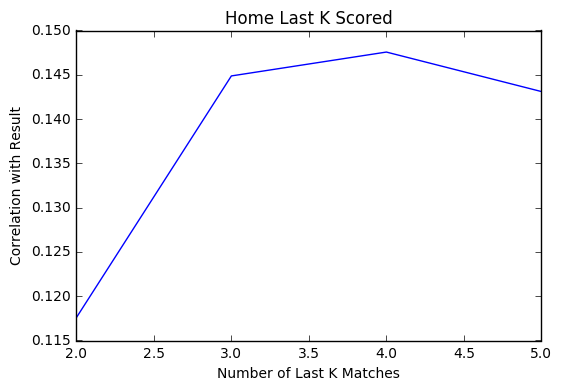

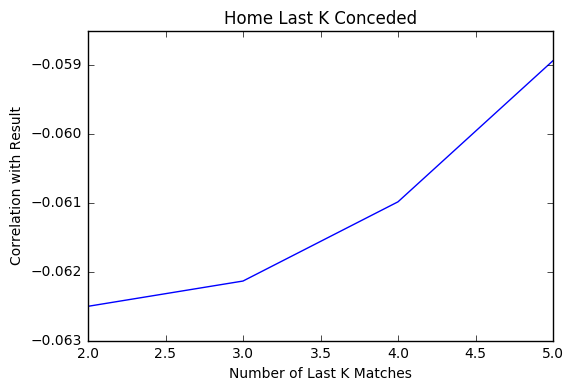

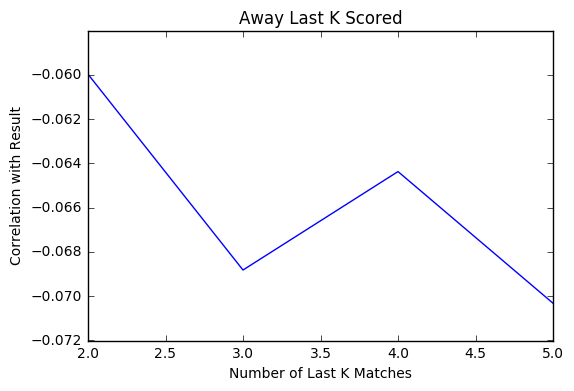

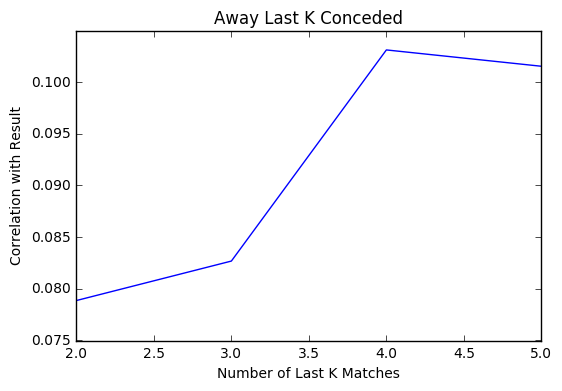

In [91]:
metric_list = ['home_last_%d_scored','home_last_%d_conceded','away_last_%d_scored','away_last_%d_concede']
count = 0
for metric in metric_list:
    corr_list = []
    count +=1
    for i in range(2,6):
        corr_list.append(pearsonr(matches[metric%i],matches['Result_Target'])[0])
    plt.plot(range(2,6),corr_list)
    plt.xlabel('Number of Last K Matches')
    plt.ylabel('Correlation with Result')
    if count == 1:
        plt.title('Home Last K Scored')
    if count == 2:
        plt.title('Home Last K Conceded')
    if count == 3:
        plt.title('Away Last K Scored')
    if count == 4:
        plt.title('Away Last K Conceded')
        
    plt.show()
        

In [94]:
metric_list = ['Home_Promoted_Flag', 'Away_Promoted_Flat']
count = 0
corr_list = []
for metric in metric_list:
    corr_list.append(pearsonr(matches[metric],matches['Result_Target'])[0])


In [102]:
print 'Home Promoted Flag Correlation with Target= ' + str(round(corr_list[0],2))
print 'Away Promoted Flag Correlation with Target= ' + str(round(corr_list[1],2))


Home Promoted Flag Correlation with Target= -0.07
Away Promoted Flag Correlation with Target= 0.09


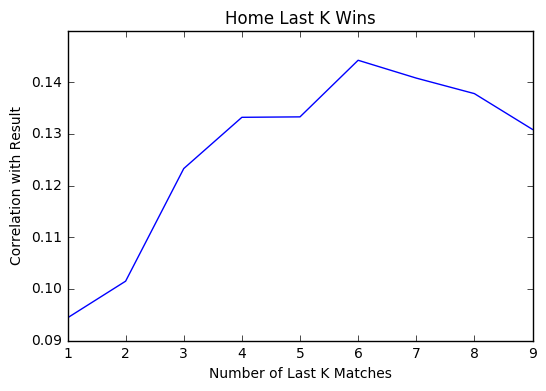

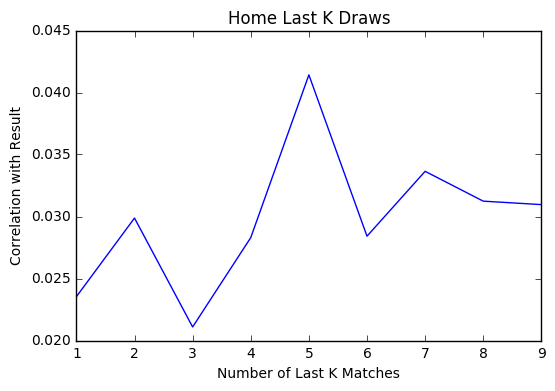

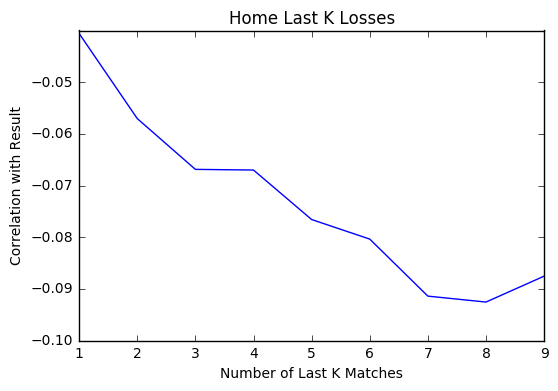

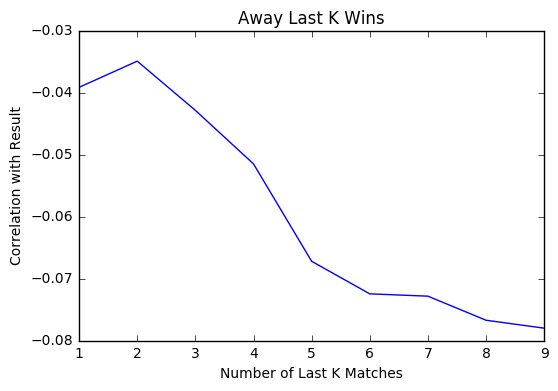

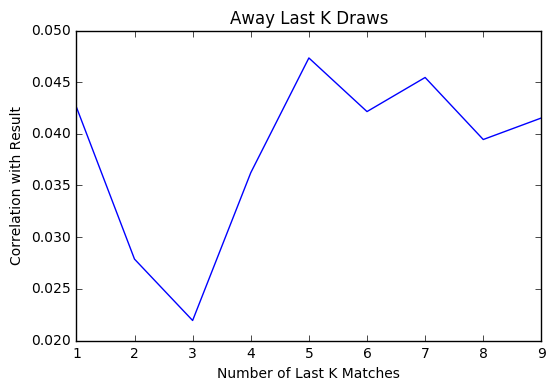

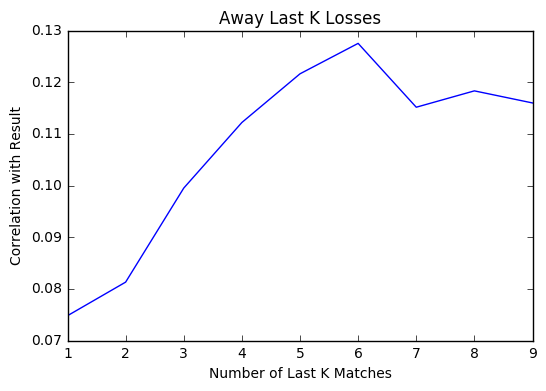

In [76]:
metric_list = ['Home_Team_Last_%d_Wins','Home_Team_Last_%d_Draws','Home_Team_Last_%d_Losses','Away_Team_Last_%d_Wins','Away_Team_Last_%d_Draws','Away_Team_Last_%d_Losses']
count = 0
for metric in metric_list:
    corr_list = []
    count +=1
    for i in range(1,10):
        corr_list.append(pearsonr(matches[metric%i],matches['Result_Target'])[0])
    plt.plot(range(1,10),corr_list)
    plt.xlabel('Number of Last K Matches')
    plt.ylabel('Correlation with Result')
    if count == 1:
        plt.title('Home Last K Wins')
    if count == 2:
        plt.title('Home Last K Draws')
    if count == 3:
        plt.title('Home Last K Losses')
    if count == 4:
        plt.title('Away Last K Wins')
    if count == 5:
        plt.title('Away Last K Draws')
    if count == 6:
        plt.title('Away Last K Losses')               
        
    plt.show()